In [1]:
from utils import  plot_error_map, plot_comp, plot_comp_invivo
from dataset import read_brainweb_sim_data, read_brainweb_sim_data_comp, read_data_invivo
import glob
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
#from model import UnetModel
import monai
import torch
import h5py
from skimage.metrics import structural_similarity
import tqdm
import pandas as pd
from torchinfo import summary
from model import UnetModel
import time

plt.rcParams.update({'font.size': 20})

In [2]:
# init the classification model
input_size = (64, 64)
spatial_dims = 2 
num_channels = 40 #metabolies*tpts

model = UnetModel.load_from_checkpoint("/home/ssahin/kpl-est-dl/checkpoints/version_20/epoch=213-val_loss=2.23.ckpt", input_size=input_size, spatial_dims=spatial_dims, num_channels=num_channels, dropout=0.3)

BasicUNet features: (32, 32, 64, 128, 256, 32).


In [3]:
# disable randomness, dropout, etc...
model.eval()

UnetModel(
  (model): BasicUNet(
    (conv_0): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(40, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.3, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (conv_1): Convolution(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.3, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
    (down_1): Down(
      (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1,

### single case predict

In [6]:
#list = pd.read_pickle("groups/test_BW_6_24")
#list2 = list["file"].to_list()

In [4]:
#data_path_val = "/data/ssahin/kpl_dl_sim/val/data"
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_6_24/sim_data_test"
#data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_4_28/sim_data_ood/new_coil_sens_2_3.h5"
list_val = glob.glob(data_path_test + '/*.h5')
dict = read_brainweb_sim_data(list_val[188]) #0,6,10, 50, 56, 60
#dict = read_brainweb_sim_data(list2[13]) #0,6,10, 50, 56, 60

torch.Size([1, 40, 64, 64])
elapsed time: 0.03263401985168457


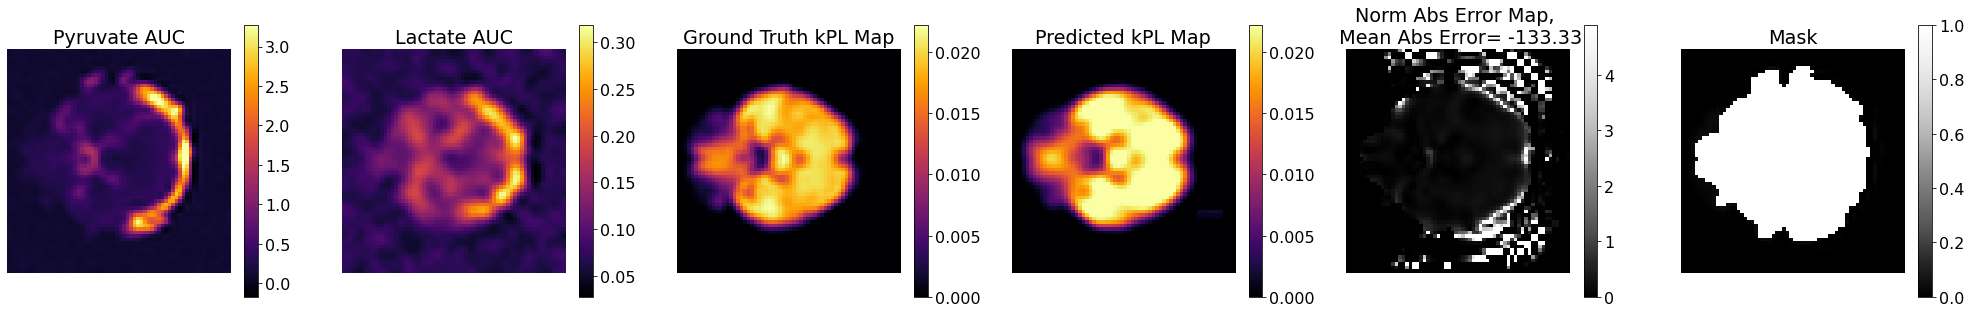

In [5]:
start = time.time()

x = torch.from_numpy(dict["data"])
x = x[None, :, :, :]
print(x.shape)
with torch.no_grad():
    kpl_pred = model(x)
kpl_pred_np = np.squeeze(kpl_pred.numpy())
end = time.time()
print("elapsed time:", end - start)

plot_error_map(dict["kPL"], kpl_pred_np, dict["data"], ktrans=dict["kTRANS"])

### single case predict test and comparisons and plot (for figure 4 and 5)

In [6]:
#data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_test/"
#list_val = glob.glob(data_path_test + '/*.h5')
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_ood/low_kPL_2.h5"
#data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_test/32_4.h5"
#dict = read_brainweb_sim_data_comp(list_val[78]) #54, 20
#print(list_val[78])
dict = read_brainweb_sim_data_comp(data_path_test)

In [7]:
x = torch.from_numpy(dict["data"])
x = x[None, :, :, :]
print(x.shape)
with torch.no_grad():
    kpl_pred = model(x)
kpl_pred_np = np.squeeze(kpl_pred.numpy())

torch.Size([1, 40, 64, 64])


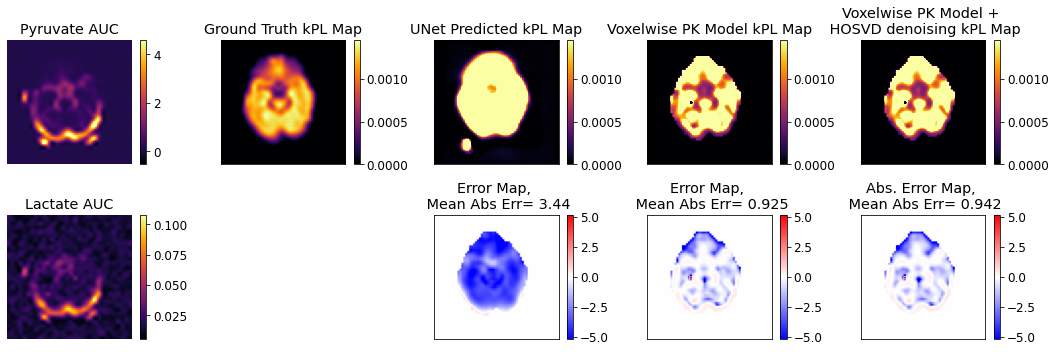

In [8]:
plot_comp(dict["data"], dict["kPL"], kpl_pred_np, dict["kPL_PK"], dict["kPL_denoise_PK"], dict["mask"])
#plot_comp(dict["kPL"], kpl_pred_np, dict["kPL_PK"], dict["kPL_denoise_PK"], dict["kPL"]>5e-4)

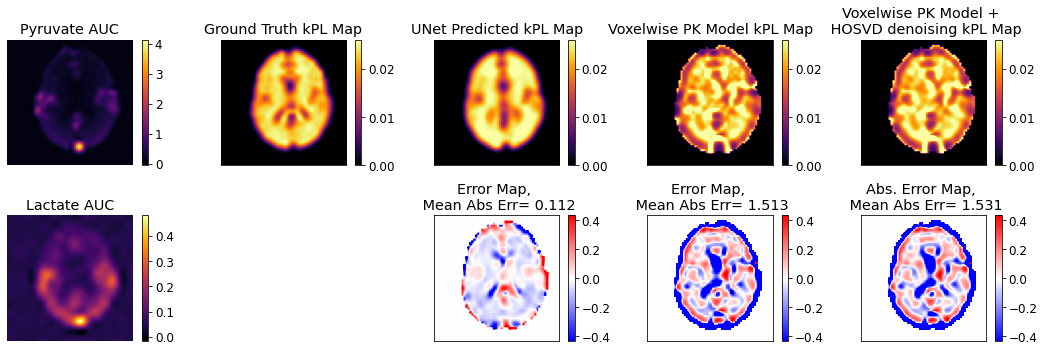

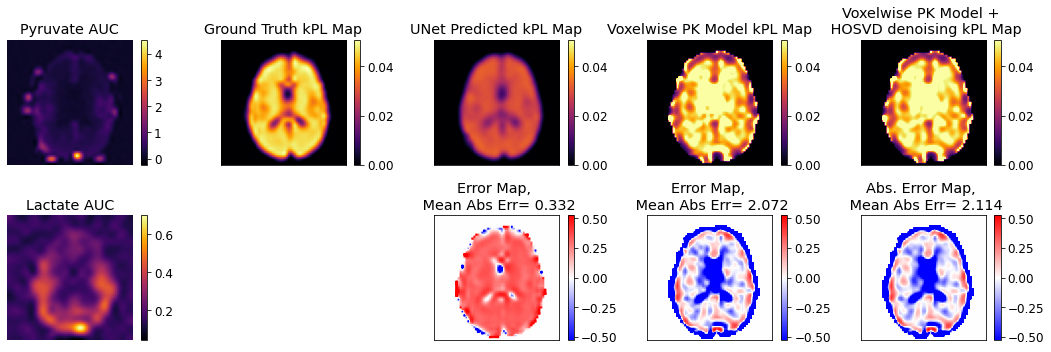

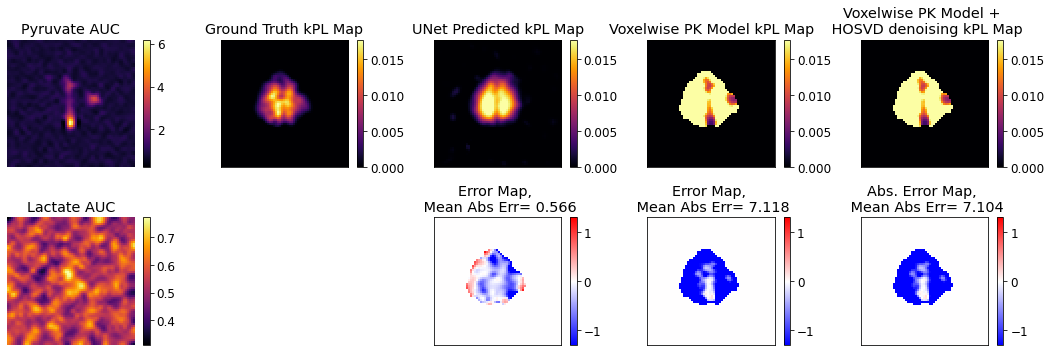

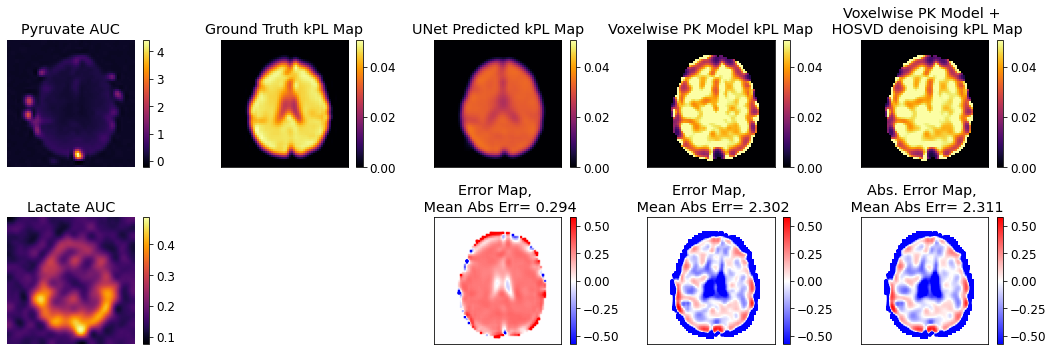

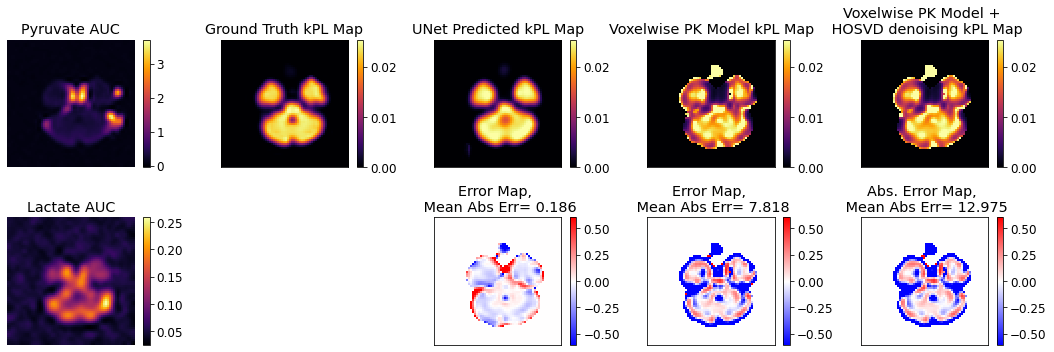

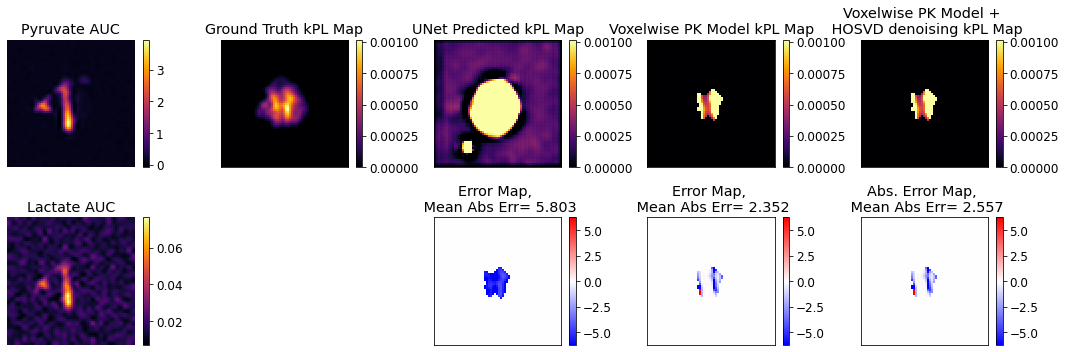

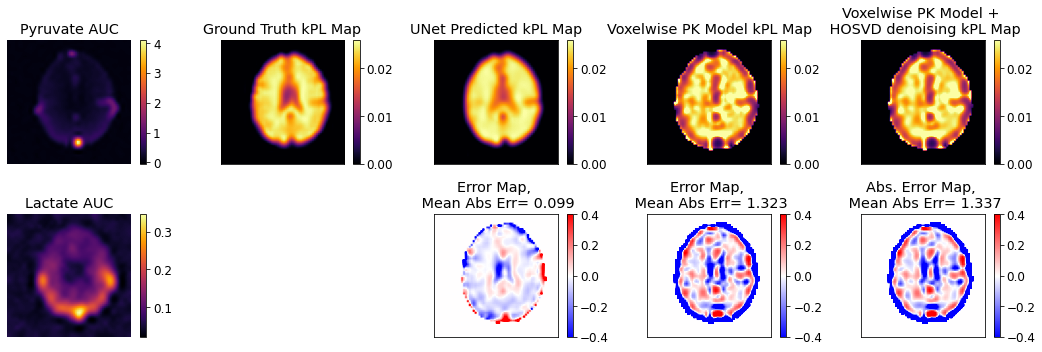

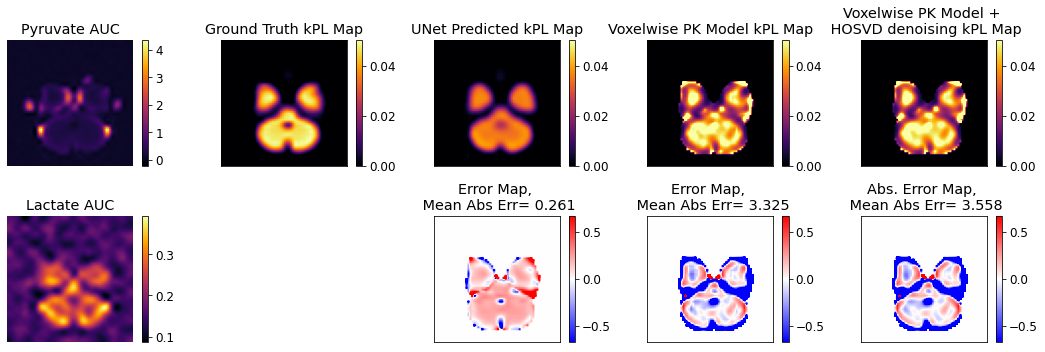

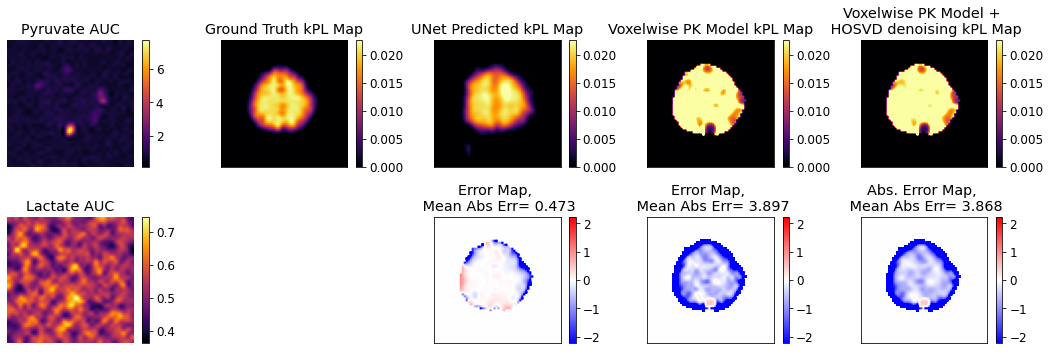

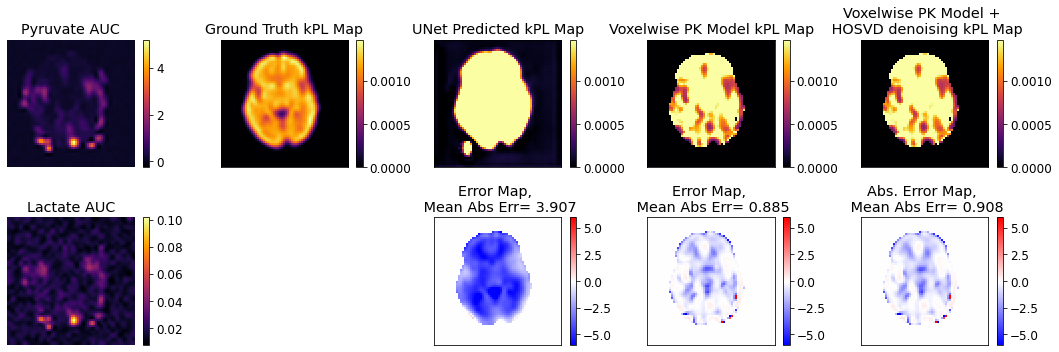

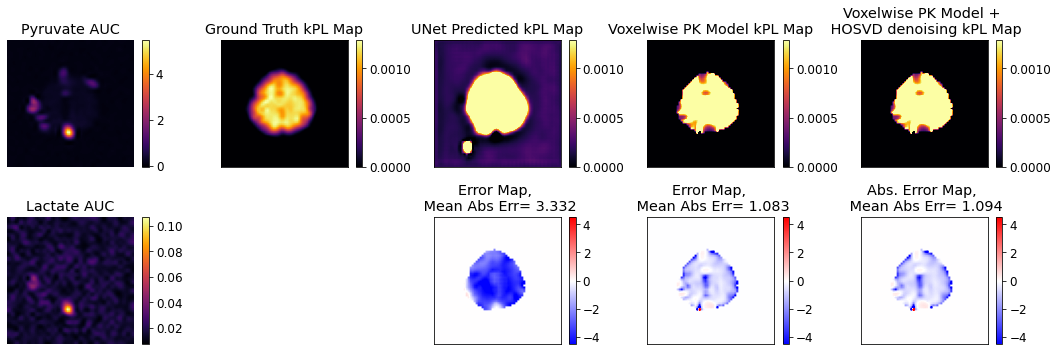

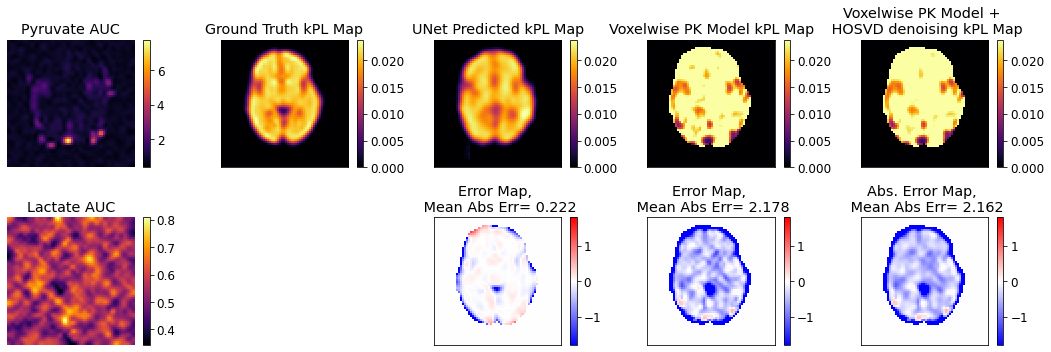

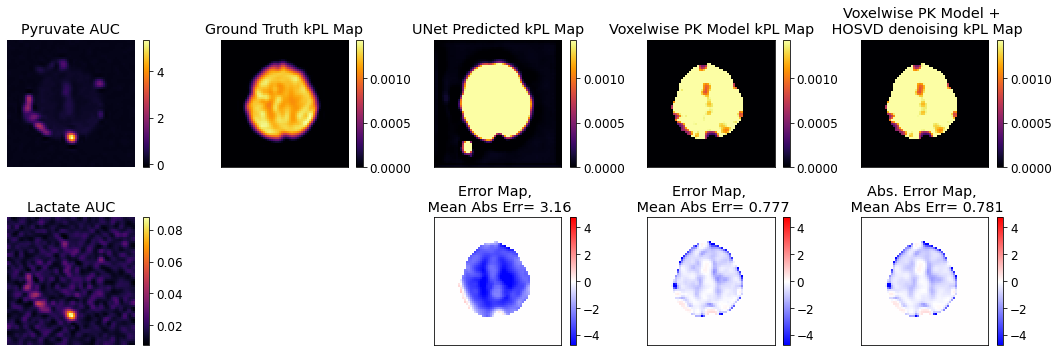

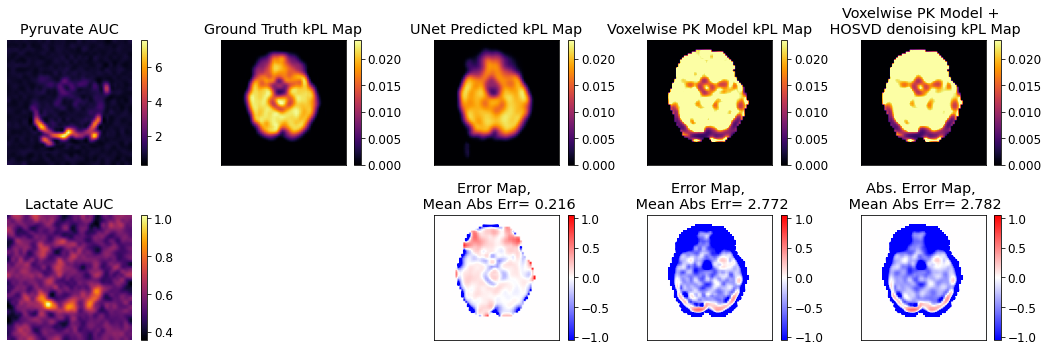

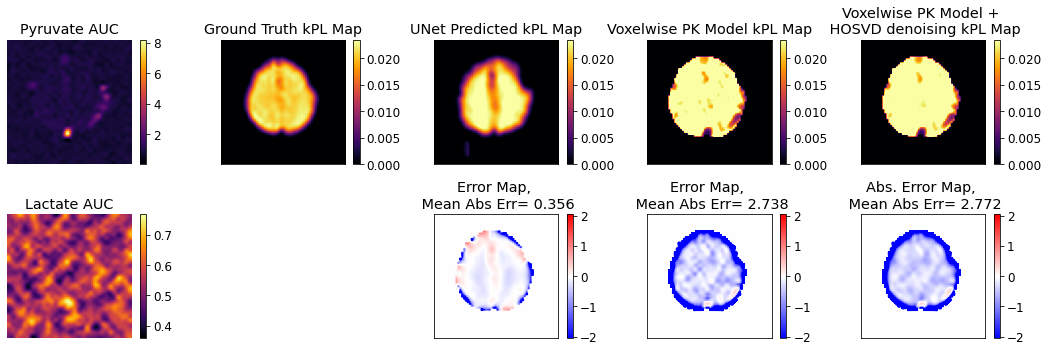

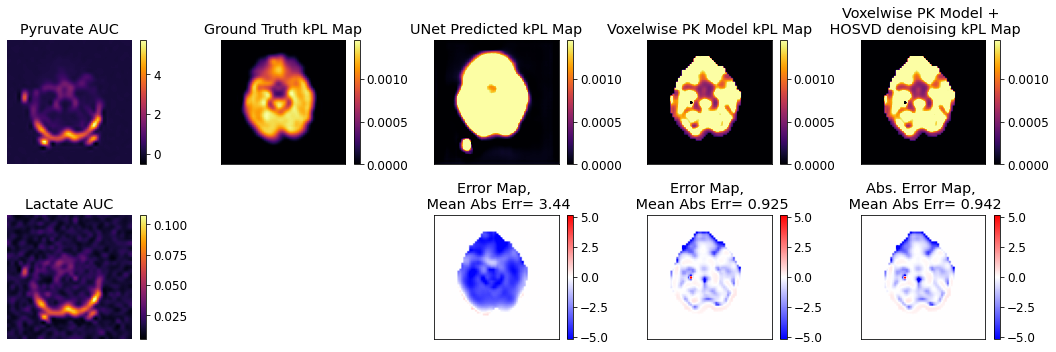

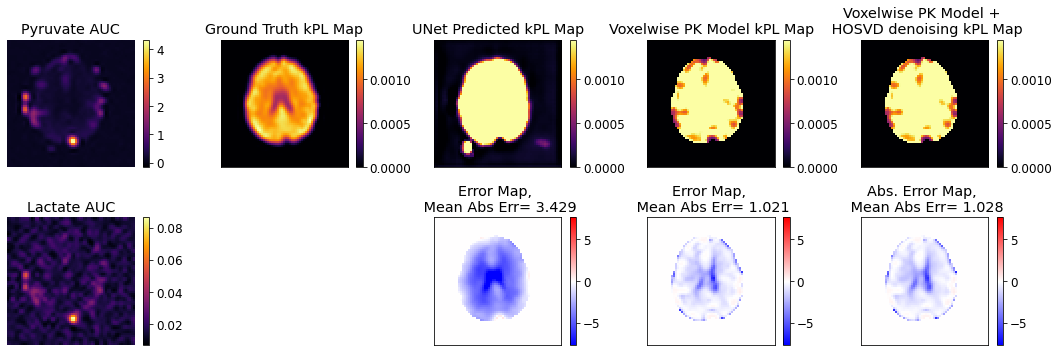

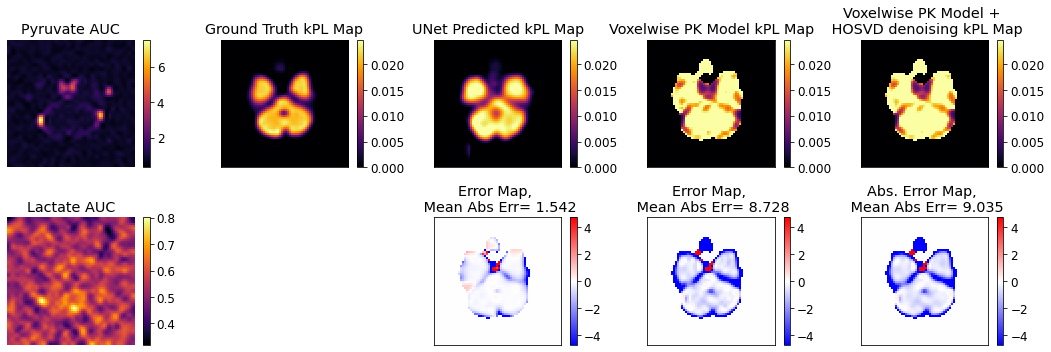

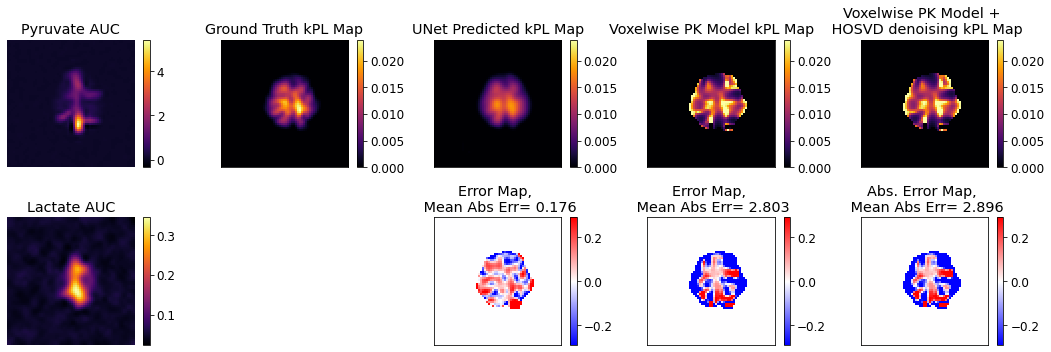

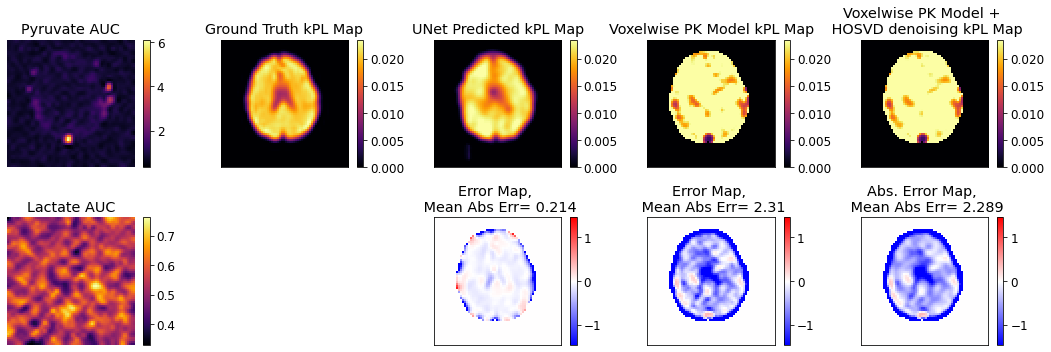

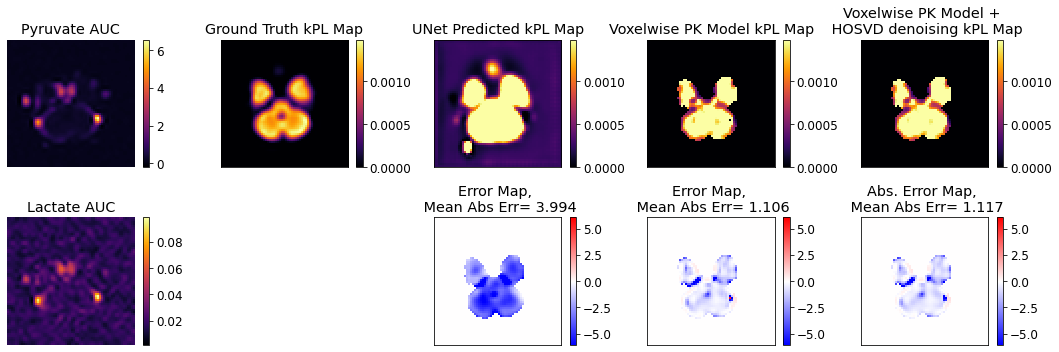

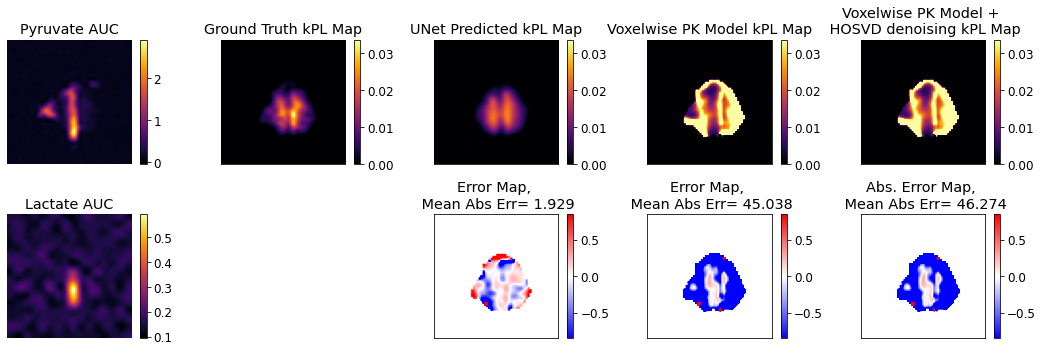

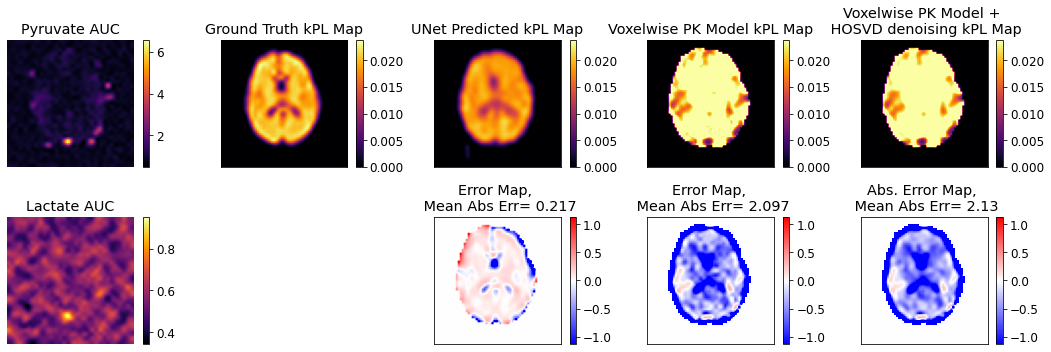

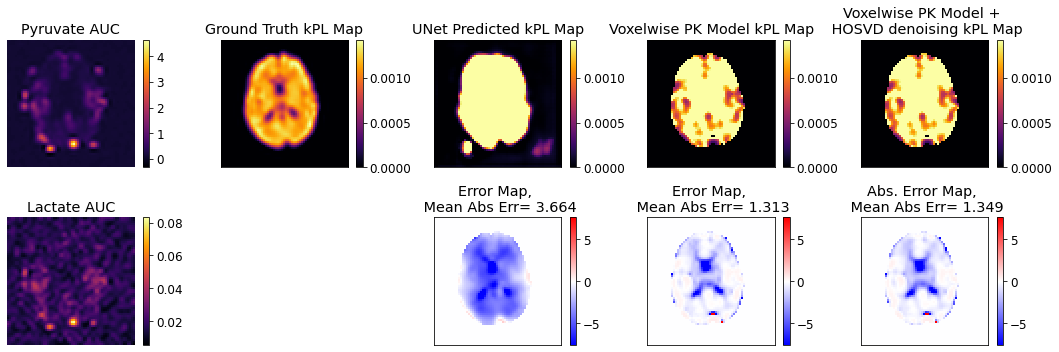

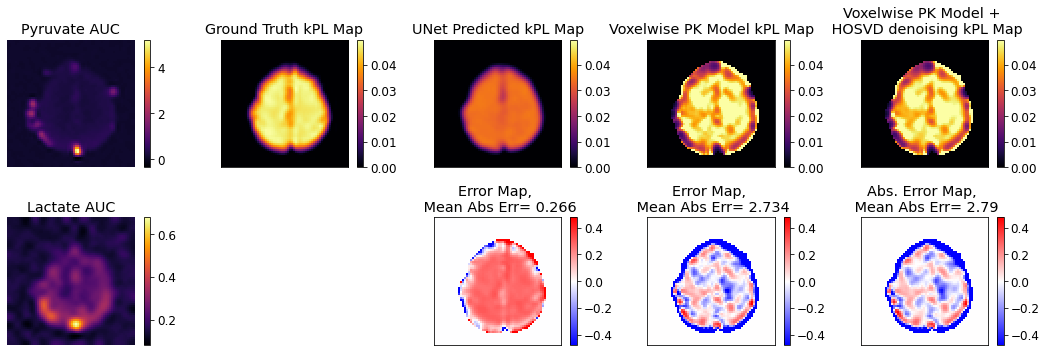

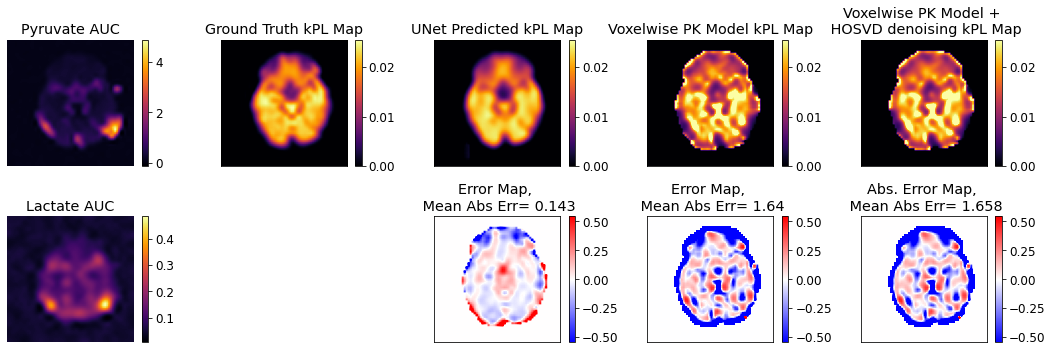

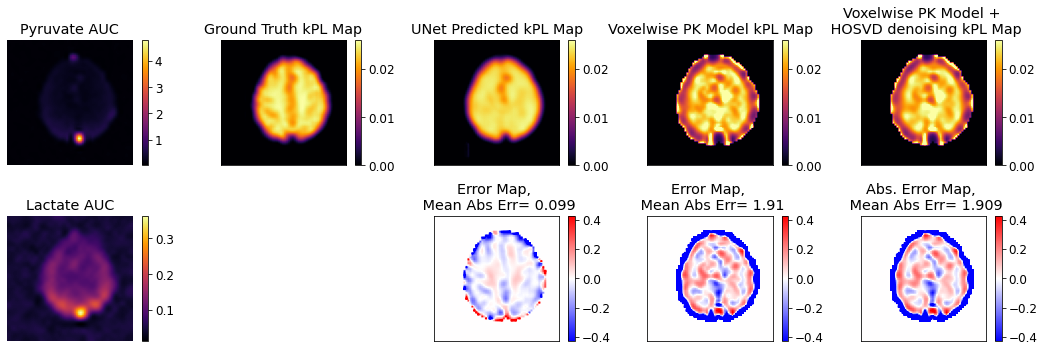

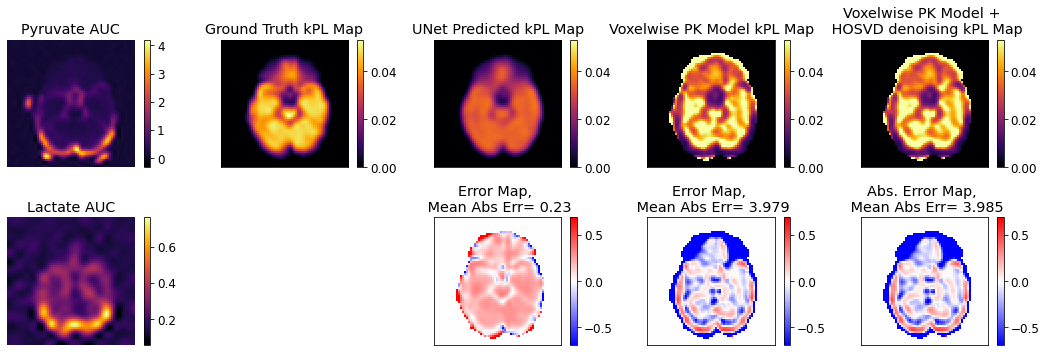

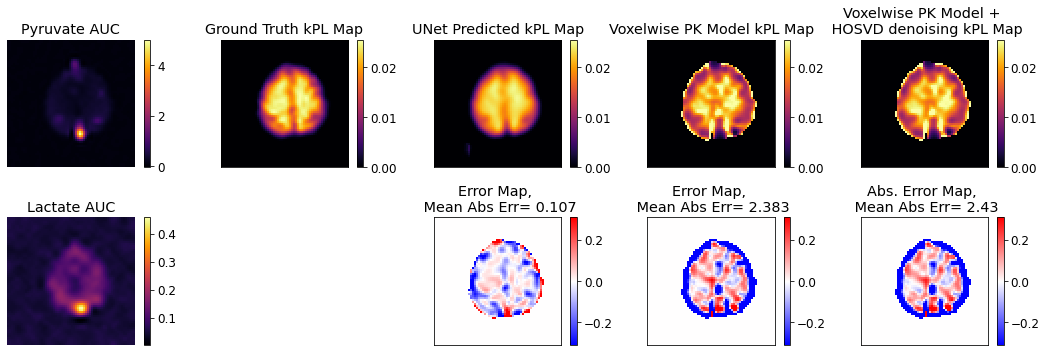

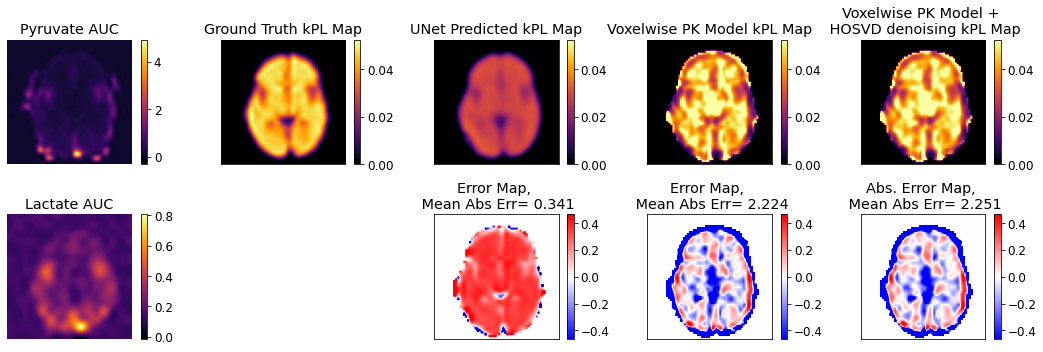

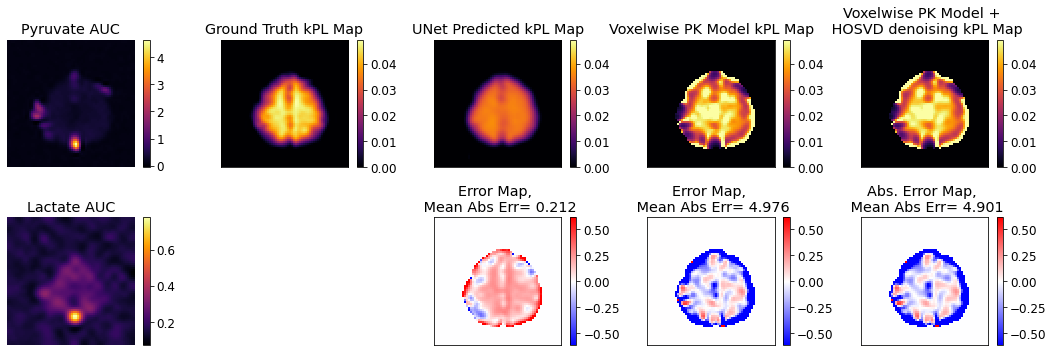

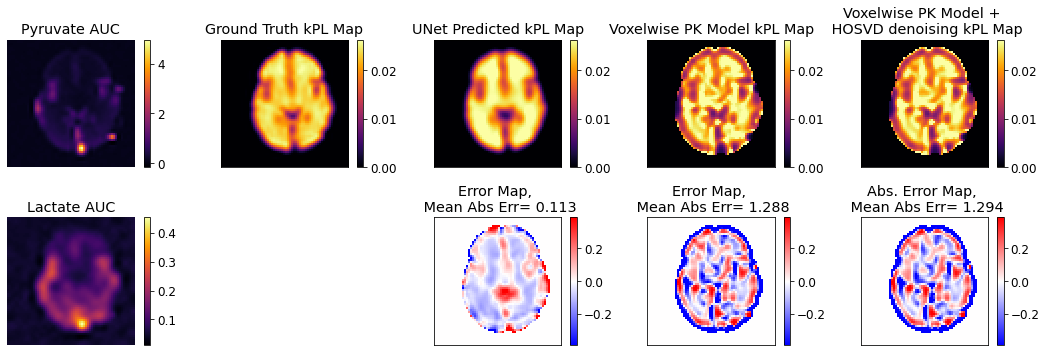

In [25]:
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_ood/"
list_val = glob.glob(data_path_test + '/*.h5')

savepath = "/home/ssahin/kpl-est-dl/test_results/version_20/comp/ood/"

for im in list_val:
    dict =read_brainweb_sim_data_comp(im)
    num = im.split("/")[-1].split(".")[0]

    x = torch.from_numpy(dict["data"])
    x = x[None, :, :, :]
    with torch.no_grad():
        kpl_pred = model(x)
    kpl_pred_np = np.squeeze(kpl_pred.numpy())

    plot_comp(dict["data"], dict["kPL"], kpl_pred_np, dict["kPL_PK"], dict["kPL_denoise_PK"], dict["mask"], savepath = (savepath+num+".png"))

### run metrics for test set

In [4]:
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/sim_data_test"
list_test = glob.glob(data_path_test + '/*.h5')


In [5]:
listt=[]

for testfile in tqdm.tqdm(list_test):
    dictt = read_brainweb_sim_data_comp(testfile)
    list_test = []

    kpl_gt = dictt["kPL"]
    kpl_pk = dictt["kPL_PK"]
    kpl_pkdn = dictt["kPL_denoise_PK"]
    mask = dictt["mask"]
    
    kpl_pk = kpl_pk * mask
    kpl_pkdn = kpl_pkdn * mask
    # # create mask
    # mask = dictt["kTRANS"]
    # mask[mask>0.1] =1
    # mask[mask<0.1] =0
    mask_nonzero = np.nonzero(mask)

    #calc abs error
    eps= 1e-12

    abs_error = abs(((kpl_gt+eps) - (kpl_pk+eps)) / (kpl_gt+eps))
    list_test.append(abs_error[mask_nonzero].mean().round(decimals=5))
    abs_error = abs(((kpl_gt+eps) - (kpl_pkdn+eps)) / (kpl_gt+eps))
    list_test.append(abs_error[mask_nonzero].mean().round(decimals=5))

    #calc sq error
    sq_error = np.square(((kpl_gt+eps) - (kpl_pk+eps))) / (kpl_gt+eps)
    list_test.append(sq_error[mask_nonzero].mean().round(decimals=5))
    sq_error = np.square(((kpl_gt+eps) - (kpl_pkdn+eps))) / (kpl_gt+eps)
    list_test.append(sq_error[mask_nonzero].mean().round(decimals=5))

    #calc ssim
    mssim, S = structural_similarity(kpl_pk, kpl_gt, data_range=np.max(kpl_gt)-np.min(kpl_gt), full=True)
    list_test.append(S[mask_nonzero].mean().round(decimals=5))
    mssim, S = structural_similarity(kpl_pkdn, kpl_gt, data_range=np.max(kpl_gt)-np.min(kpl_gt), full=True)
    list_test.append(S[mask_nonzero].mean().round(decimals=5))

    listt.append(list_test)

100%|██████████| 400/400 [00:01<00:00, 263.54it/s]


In [6]:
print(listt)

[[2.67184, 2.67961, 0.08654, 0.08631, 0.14712, 0.14633], [11.79418, 14.46762, 0.50101, 0.82445, 0.29913, 0.29501], [0.58179, 0.57559, 0.00296, 0.00288, 0.56845, 0.5821], [1.9023, 1.90578, 0.04534, 0.04474, 0.35539, 0.36557], [2.03677, 2.07546, 0.03777, 0.04136, 0.38484, 0.38221], [6.17129, 6.24126, 0.37593, 0.38415, -0.00306, -0.00627], [0.8175, 0.81269, 0.00926, 0.00911, 0.41165, 0.42488], [6.60265, 6.71669, 0.11252, 0.11557, 0.06475, 0.06574], [0.64549, 0.64559, 0.00542, 0.00522, 0.55368, 0.55782], [0.71746, 0.7246, 0.00402, 0.00415, 0.3783, 0.39116], [6.22458, 6.27805, 0.1996, 0.20164, 0.09547, 0.09321], [1.37092, 1.38045, 0.02355, 0.02404, 0.46847, 0.47939], [10.59271, 10.77632, 0.51126, 0.54572, 0.04715, 0.04135], [6.02884, 6.14406, 0.25043, 0.26057, 0.15848, 0.15734], [8.96936, 8.79483, 0.23625, 0.20626, 0.37999, 0.38796], [1.53759, 1.55698, 0.01146, 0.01158, 0.41733, 0.42286], [5.33758, 5.29626, 0.4961, 0.48337, 0.10872, 0.10725], [10.29285, 10.31825, 1.10159, 1.0884, 0.05136, 0

In [7]:
#df = pd.DataFrame({'SSIM_PK': ssim_pk_lt, 'SSIM_PK_DN': ssim_pkdn_lt, 'Abs Err PK': sae_pk, 'Abs Err PK DN': sae_pkdn, 'Sq Err PK': sse_pk, 'Sq Err PK DN': sse_pkdn})
df = pd.DataFrame(listt, columns=['Abs Err PK', 'Abs Err PK DN', 'Sq Err PK', 'Sq Err PK DN', 'SSIM PK', 'SSIM PK DN'])
print(df.head())

   Abs Err PK  Abs Err PK DN  Sq Err PK  Sq Err PK DN  SSIM PK  SSIM PK DN
0     2.67184        2.67961    0.08654       0.08631  0.14712     0.14633
1    11.79418       14.46762    0.50101       0.82445  0.29913     0.29501
2     0.58179        0.57559    0.00296       0.00288  0.56845     0.58210
3     1.90230        1.90578    0.04534       0.04474  0.35539     0.36557
4     2.03677        2.07546    0.03777       0.04136  0.38484     0.38221


In [8]:
filepath = './test_results/version_20/comp/comp_metrics_new_masked.csv'
df.to_csv(filepath)

In [17]:
### ??

dictt = read_brainweb_sim_data_comp(list_test[0])
ktrans = dictt["kTRANS"]

mask =ktrans
mask[mask>0] =1
plt.imshow(mask)
plt.colorbar()
plt.show()

kpl_gt = dictt["kPL"]
kpl_pk = dictt["kPL_PK"]
mask_nonzero = np.nonzero(mask)
print(mask_nonzero[0].shape)
mssim, S = structural_similarity(kpl_pk, kpl_gt, data_range=np.max(kpl_gt)-np.min(kpl_gt), full=True)
print(S[mask_nonzero].mean())
#print(len(img_error[mask_nonzero]))


#plt.imshow(S)
#plt.colorbar()
#plt.show()


TypeError: expected str, bytes or os.PathLike object, not numpy.float64

### run comp for real data case

In [9]:
data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/"
list_val = glob.glob(data_path_test + '/*.h5')
#data_path_test = "/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/11_2_4.h5"
dict = read_data_invivo(list_val[10]) #54, 20
#dict = read_data_invivo(data_path_test) #54, 20
print(list_val[10])

/data/ssahin/kpl_dl_sim/brainweb_9_2/invivo_test/10_6_5.h5


In [10]:
start = time.time()
x = torch.from_numpy(dict["data"])
x = x[None, :, :, :]
print(x.shape)
with torch.no_grad():
    kpl_pred = model(x)
kpl_pred_np = np.squeeze(kpl_pred.numpy())
end = time.time()
print("elapsed time:", end - start)

torch.Size([1, 40, 64, 64])
elapsed time: 0.020308494567871094


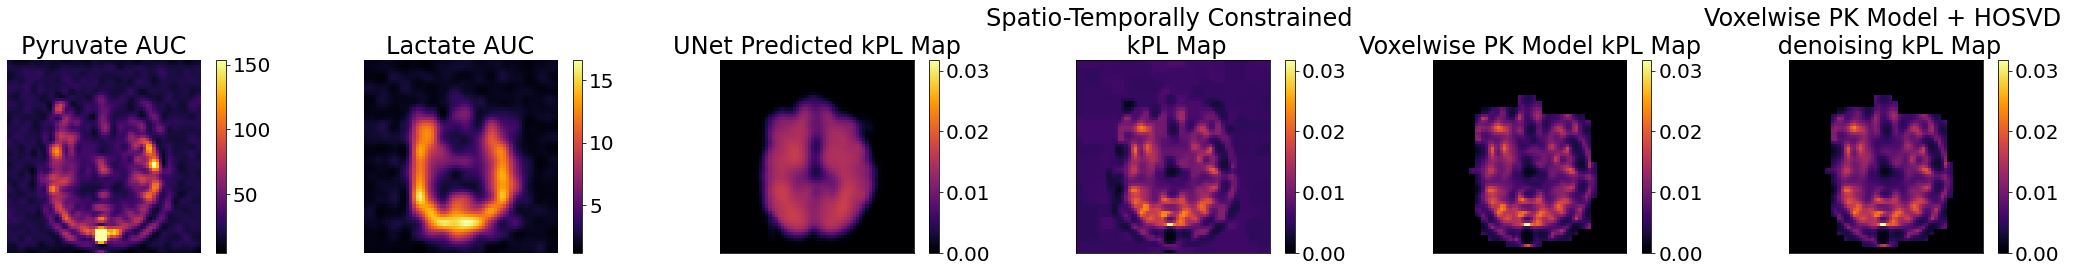

In [11]:
plt.rcParams.update({'font.size': 20})
plot_comp_invivo(dict["data"], kpl_pred_np, dict["kPL_const"], dict["kPL_PK"], dict["kPL_denoise_PK"], dict["mask"])

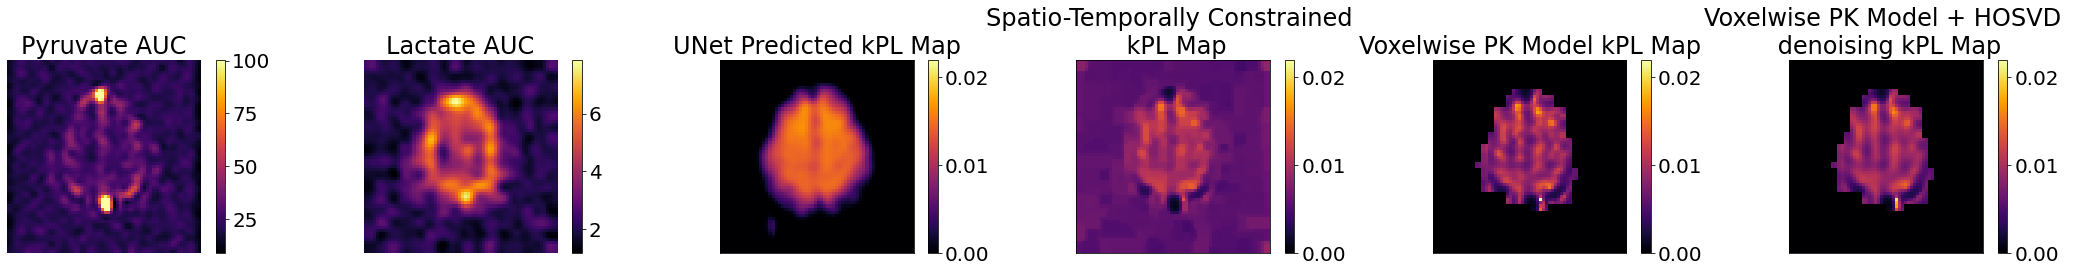

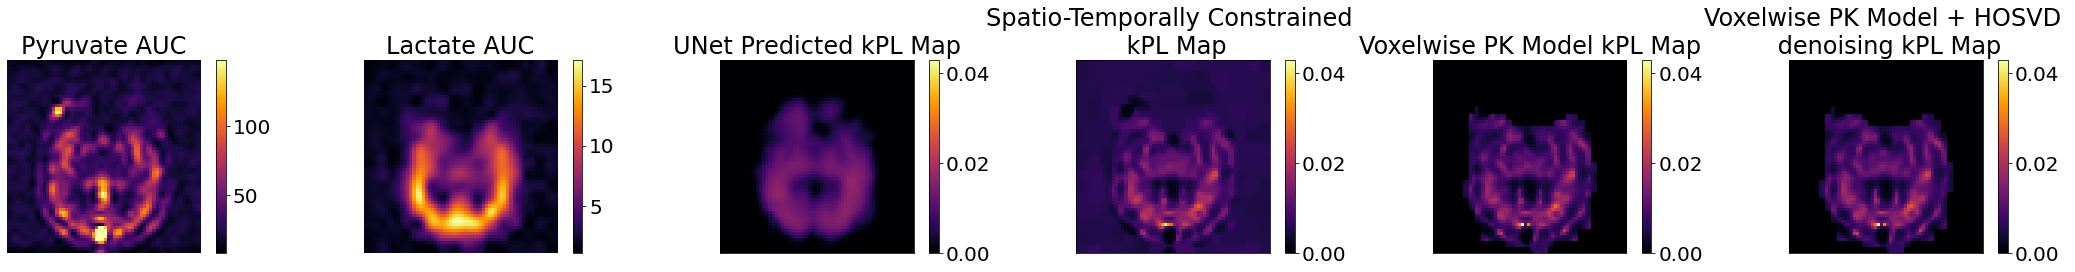

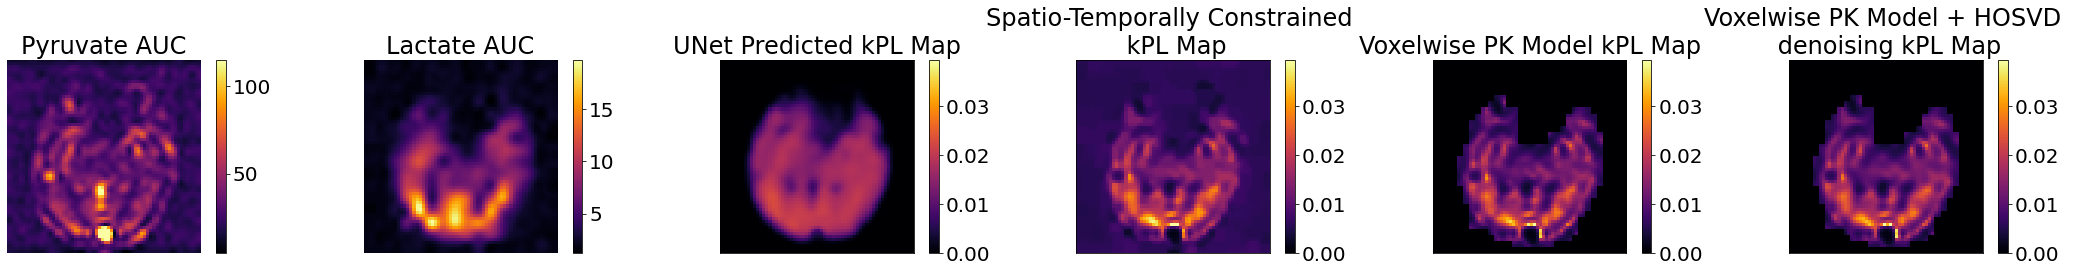

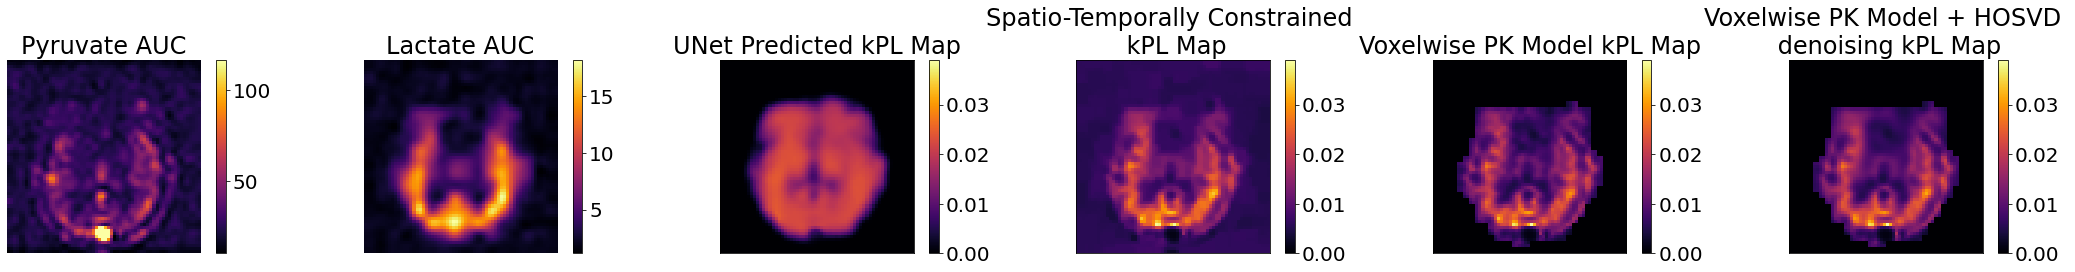

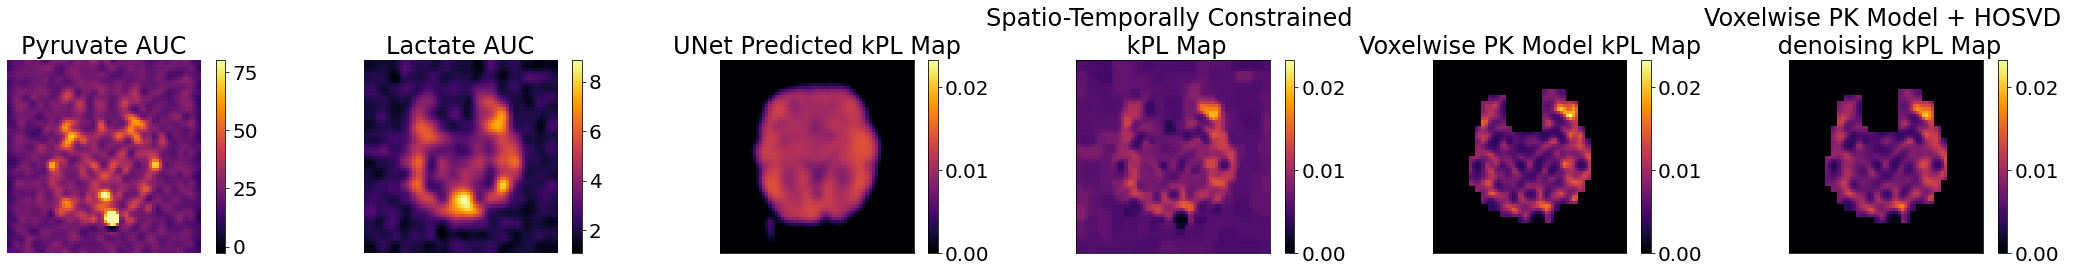

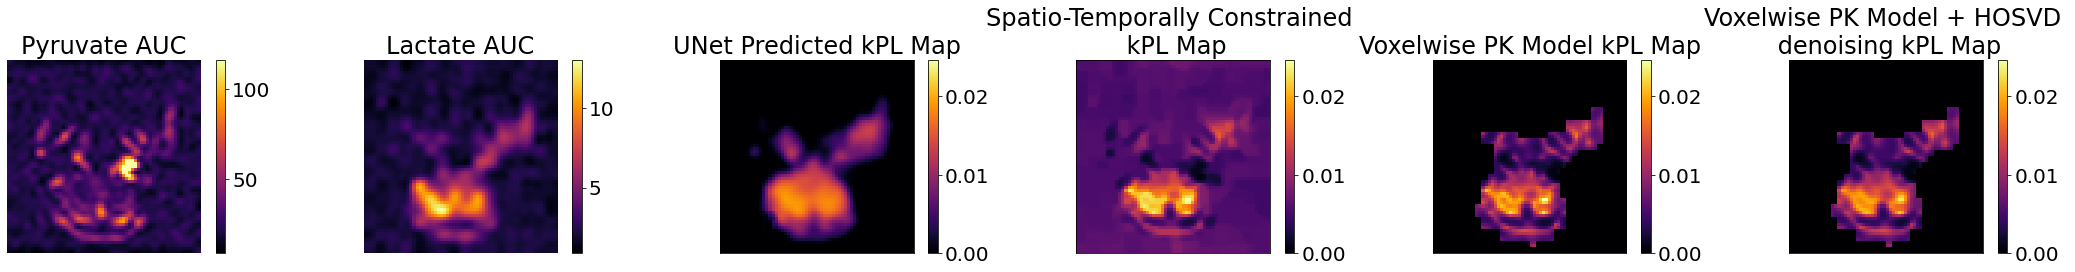

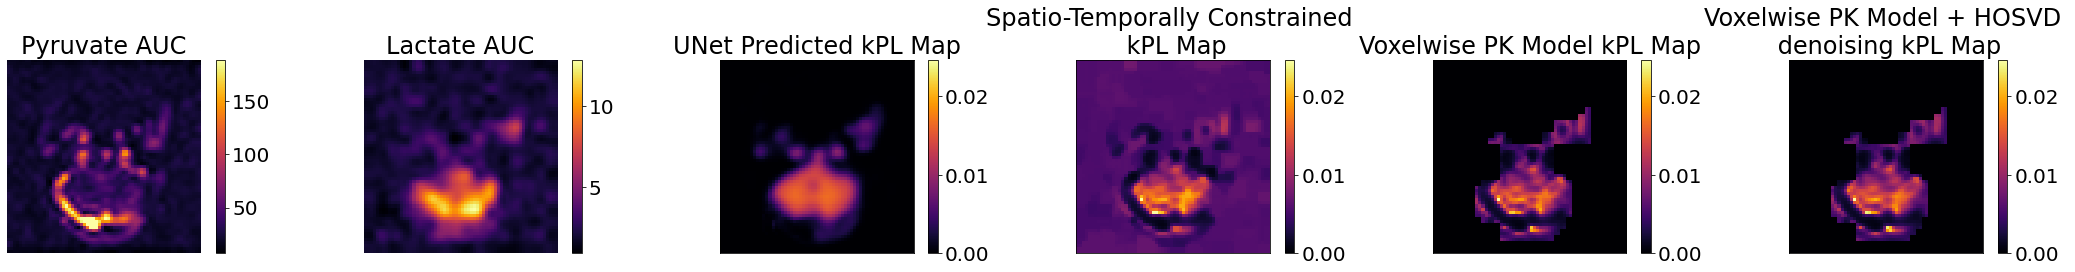

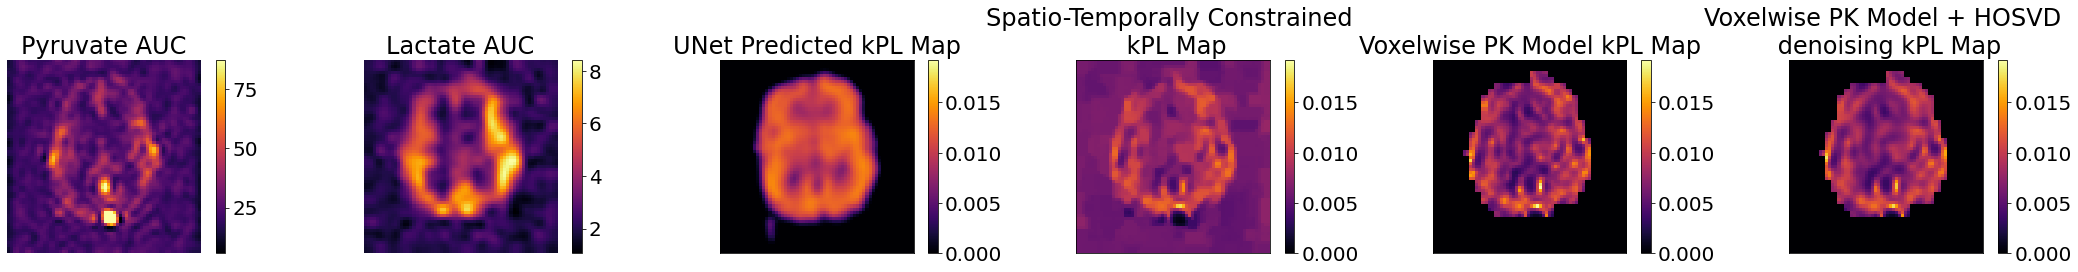

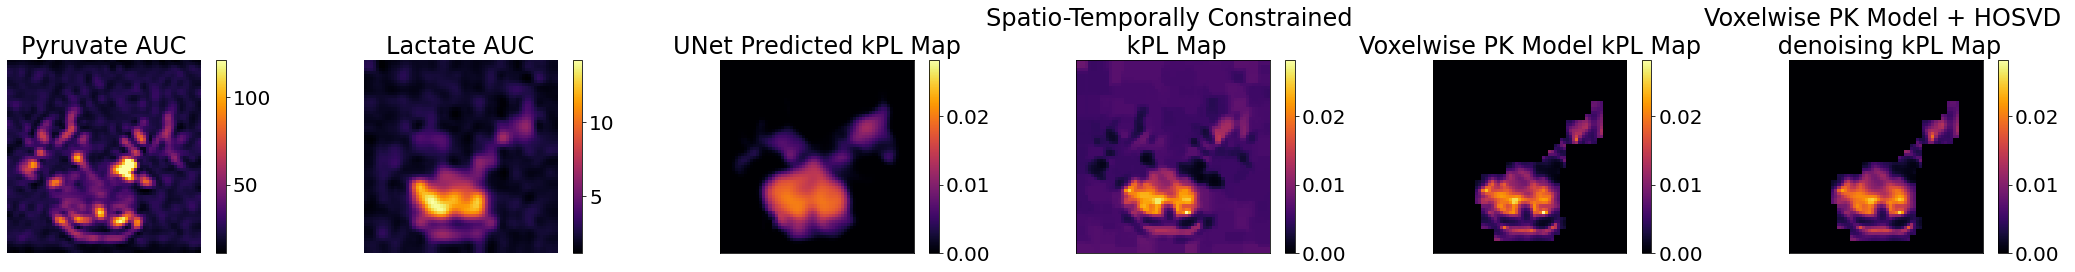

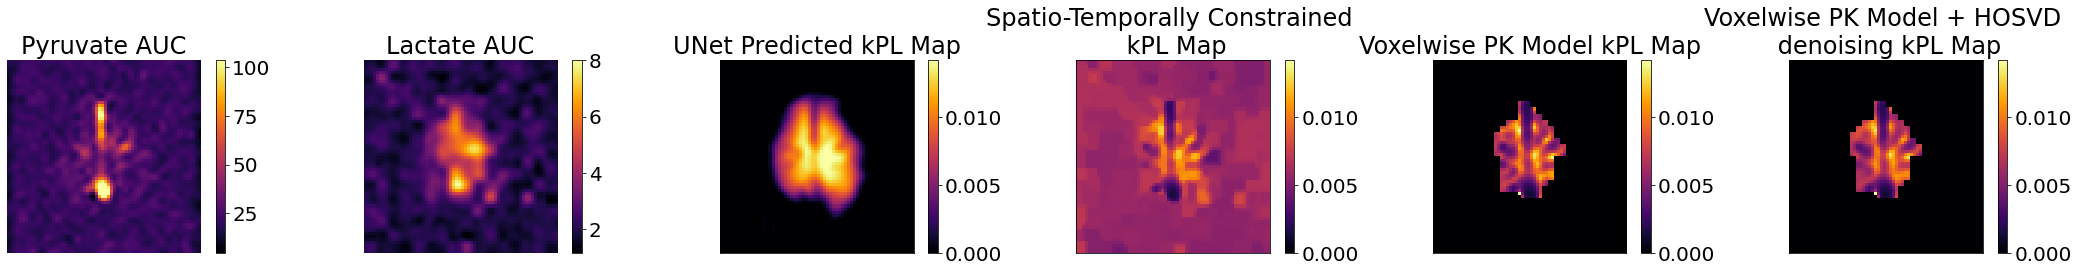

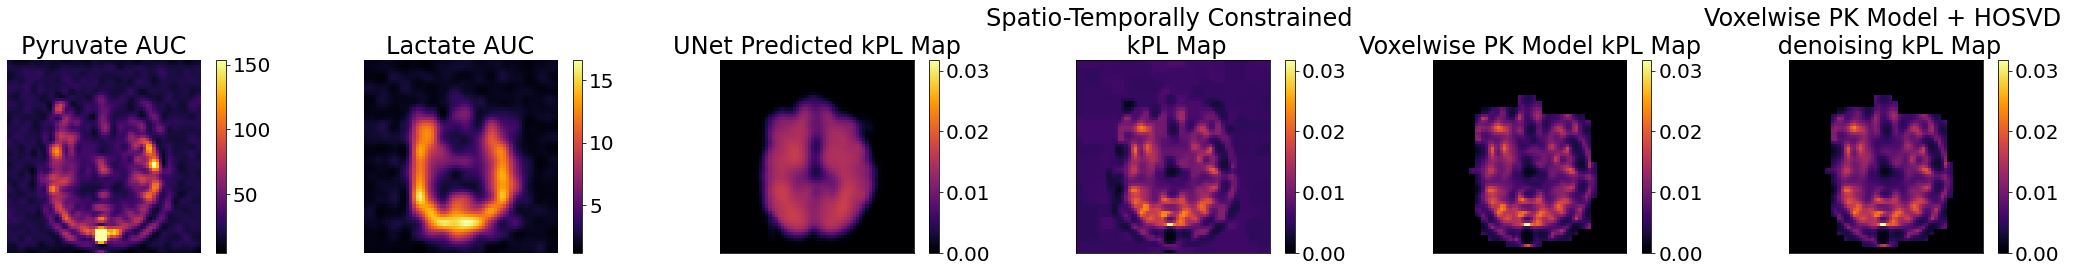

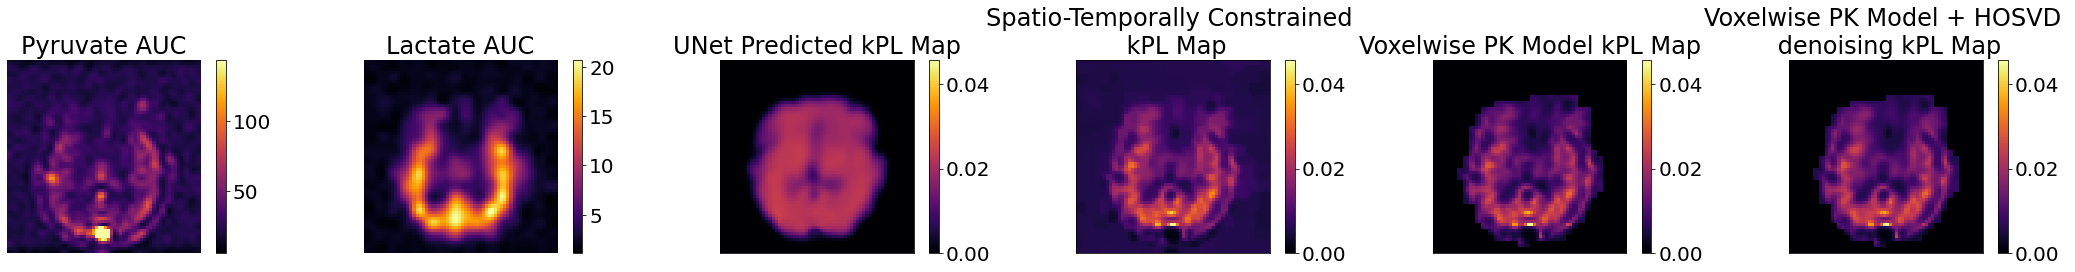

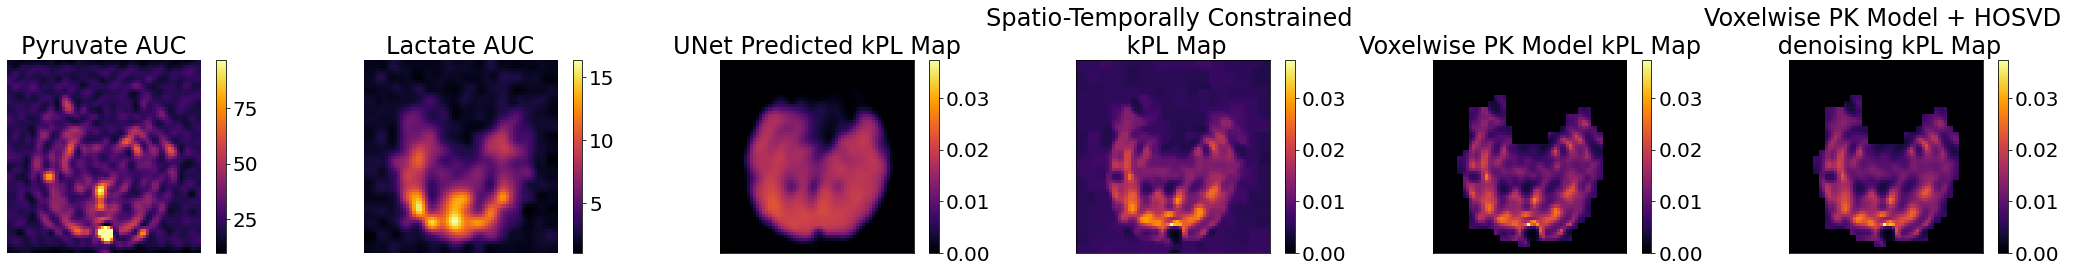

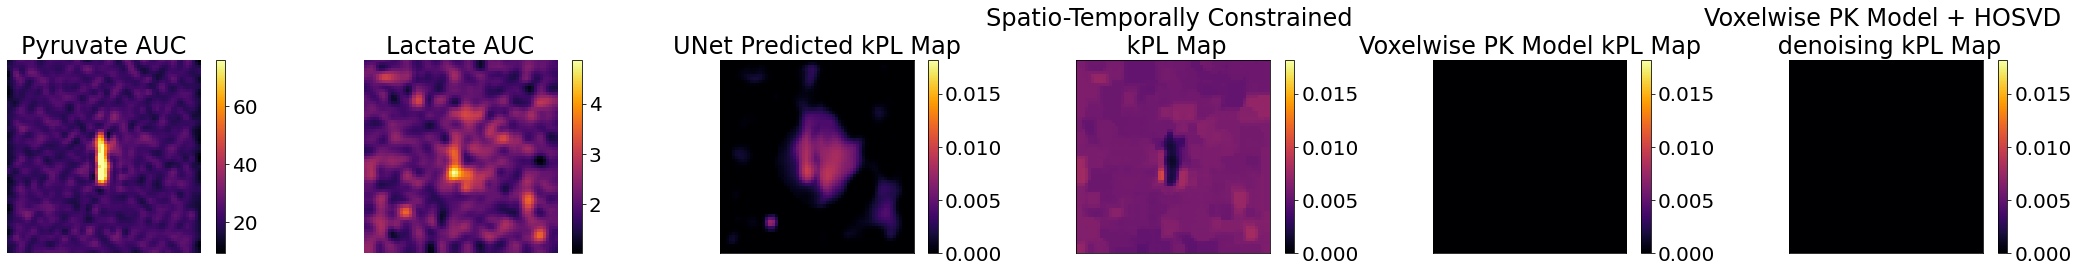

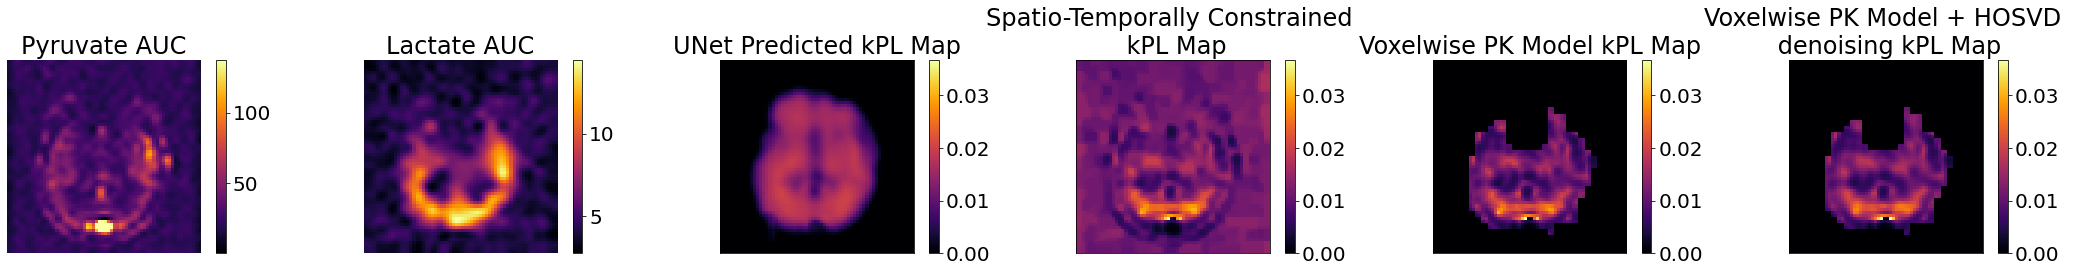

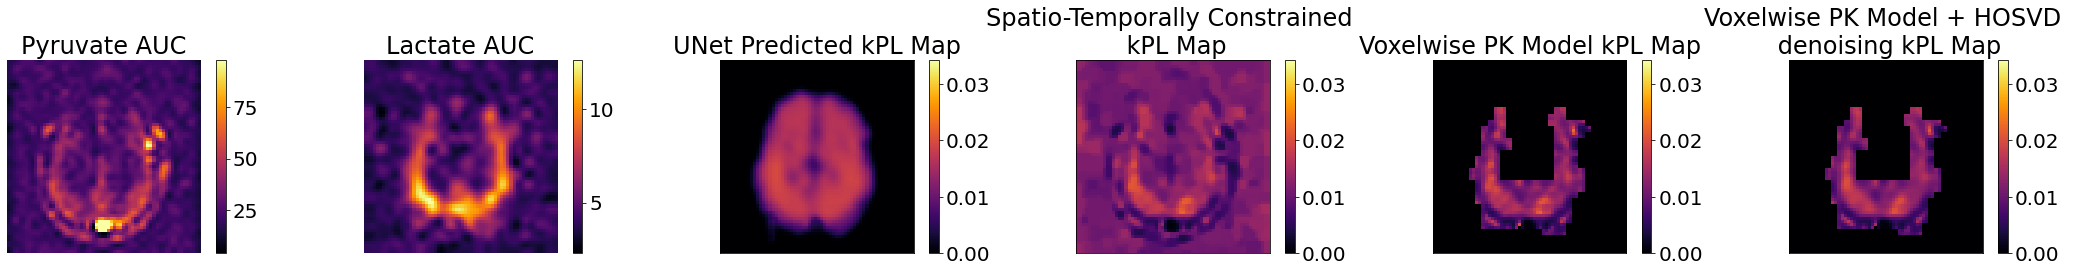

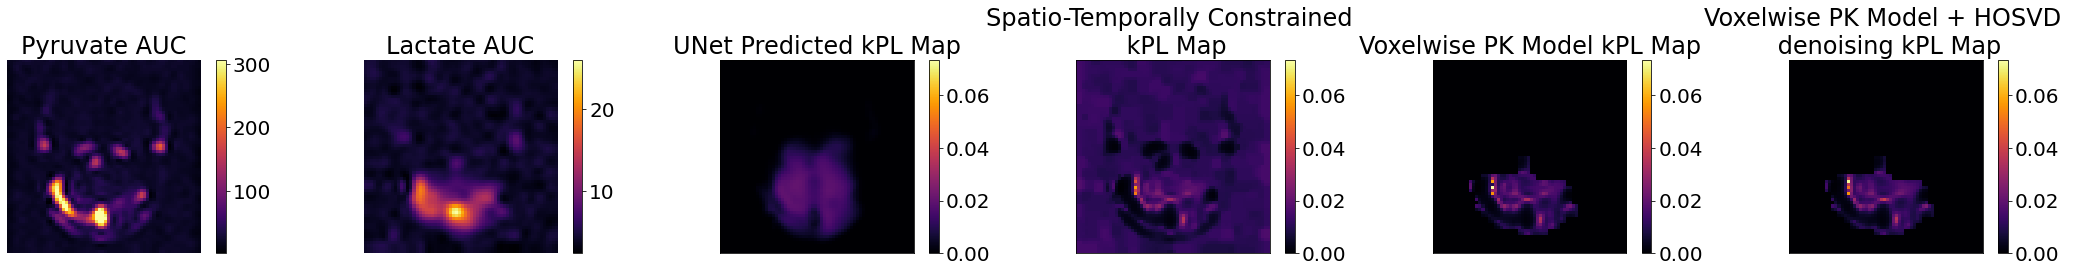

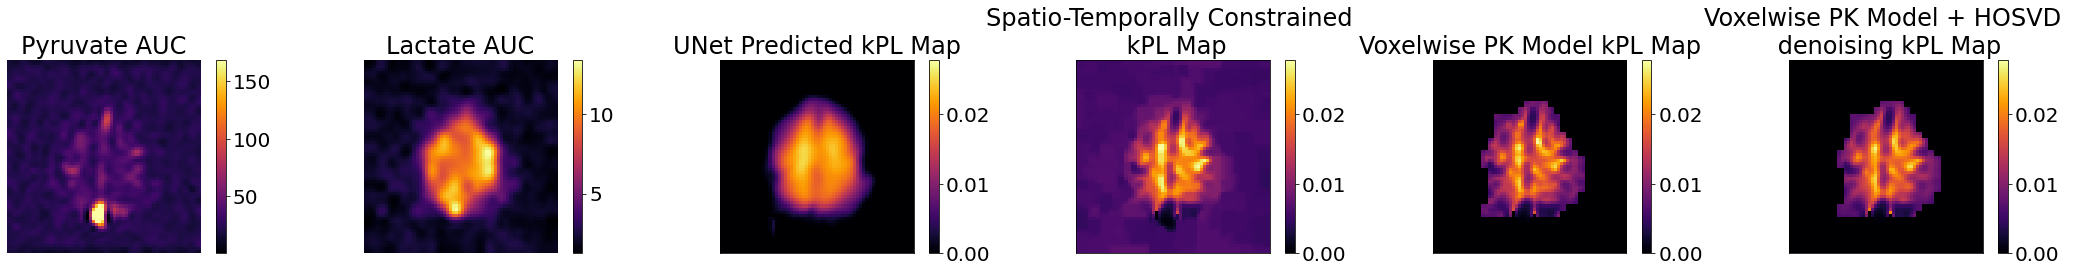

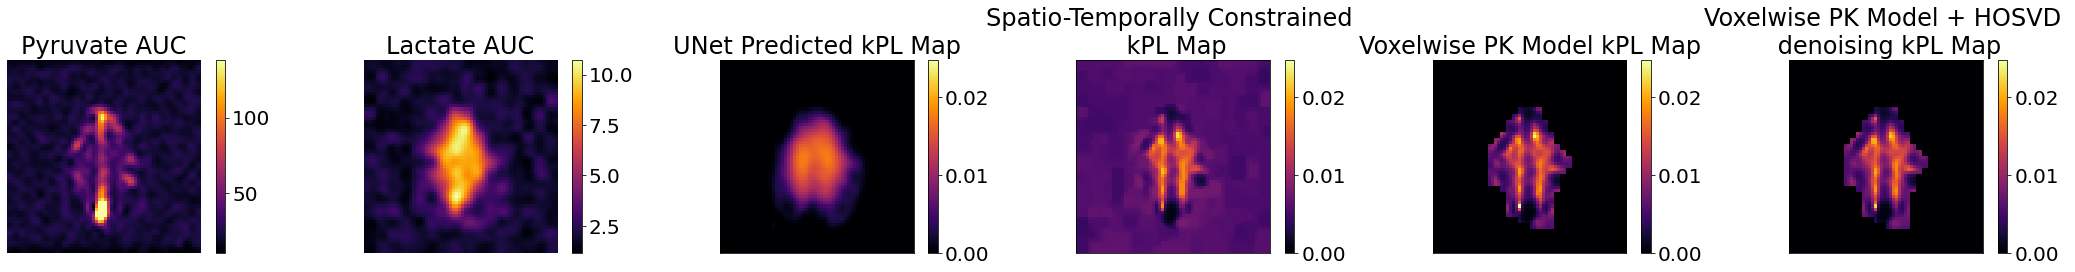

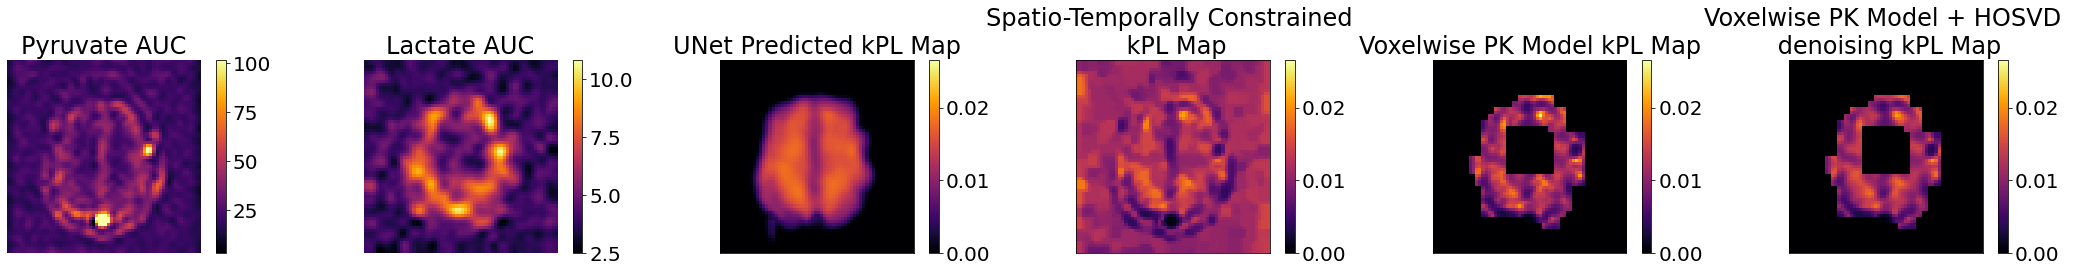

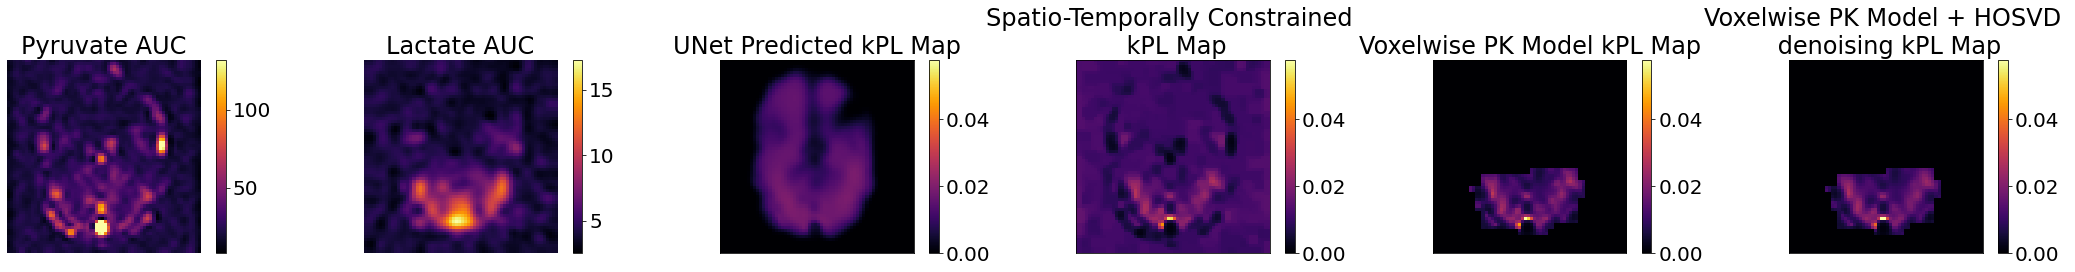

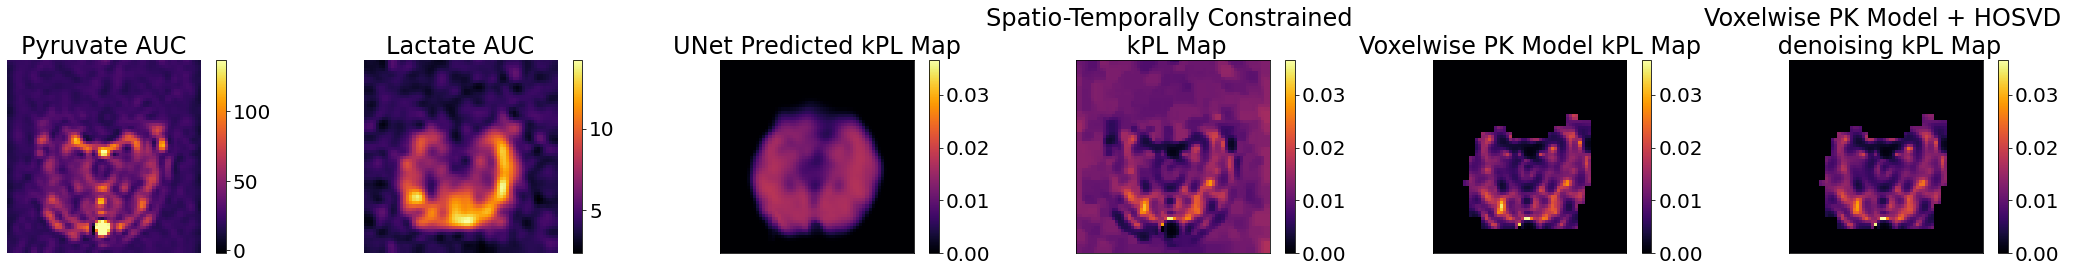

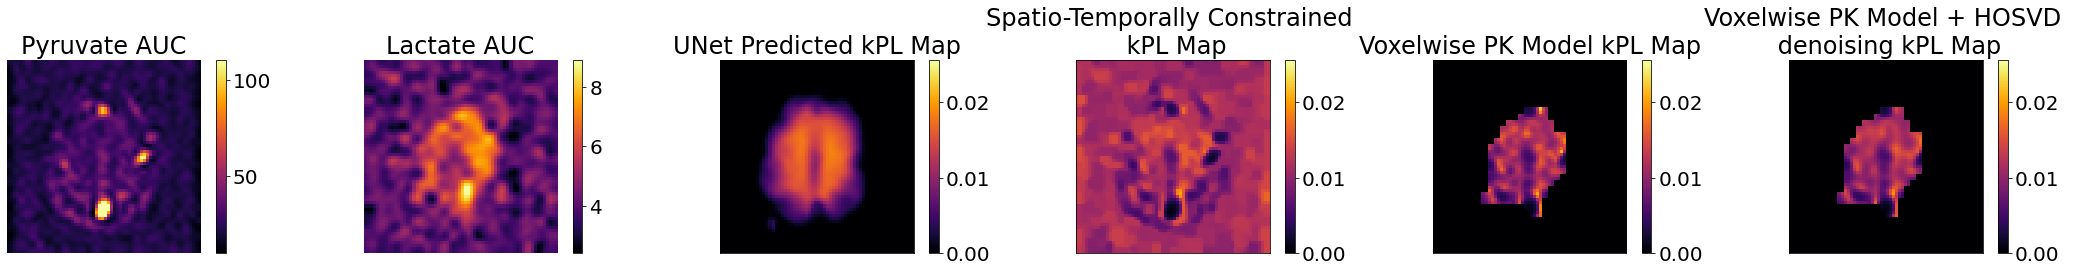

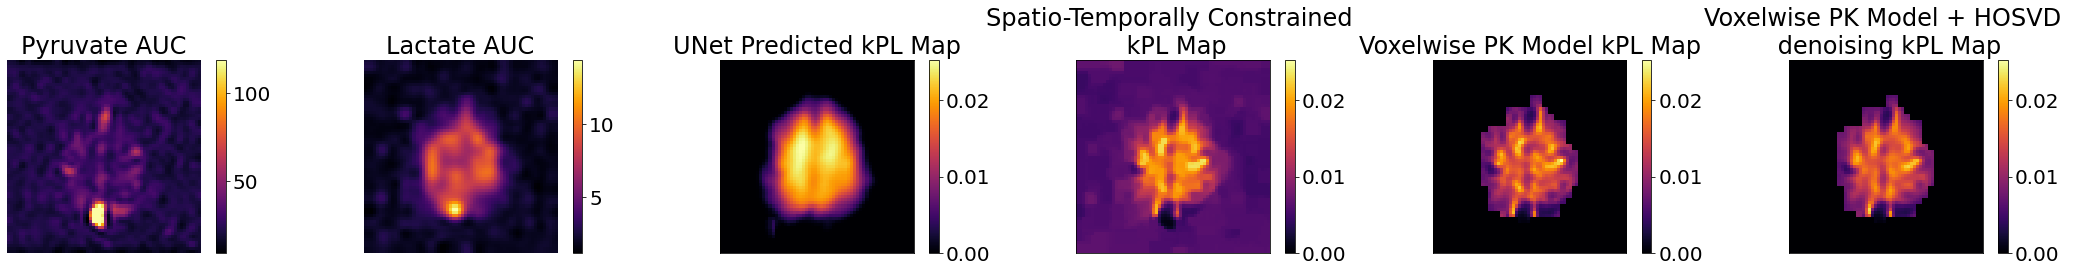

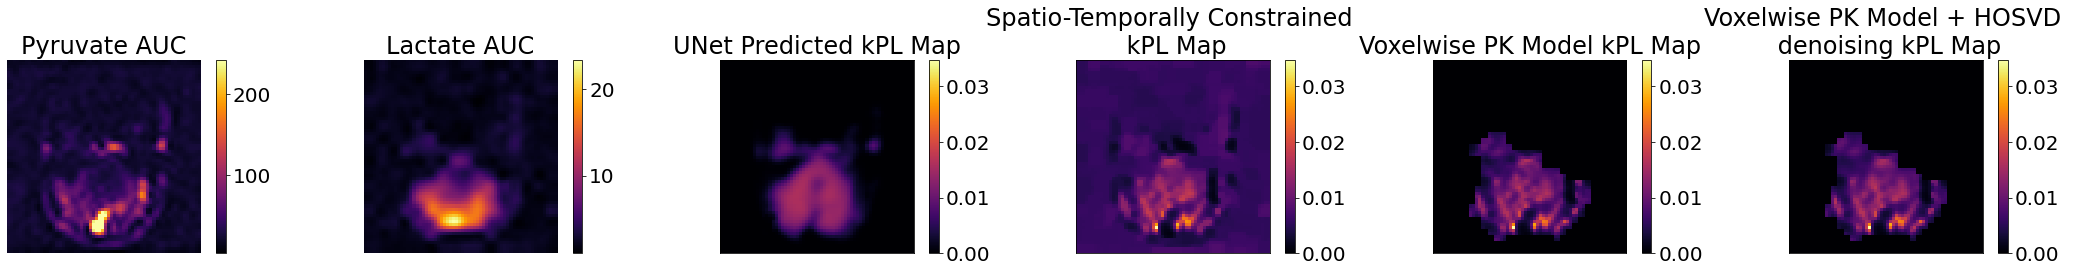

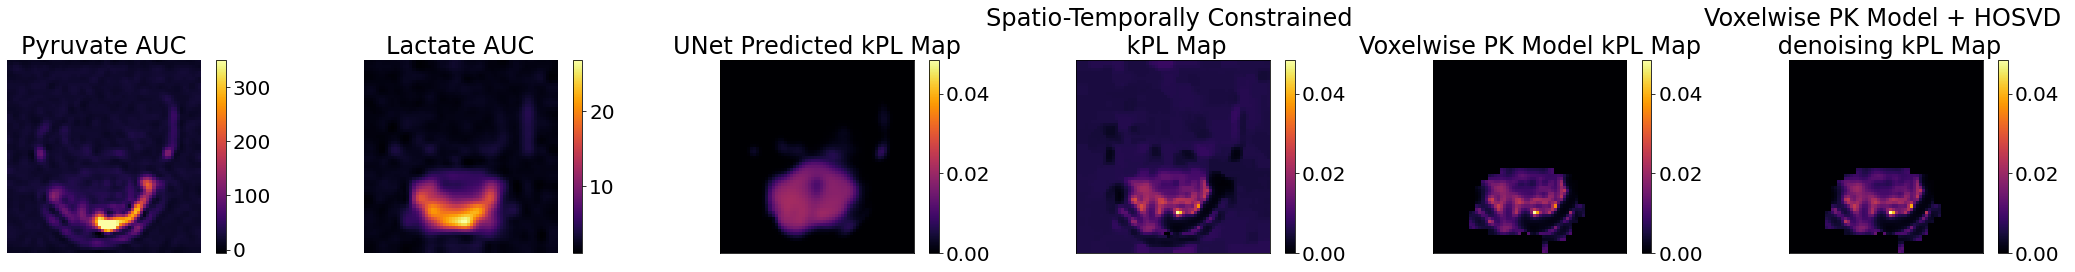

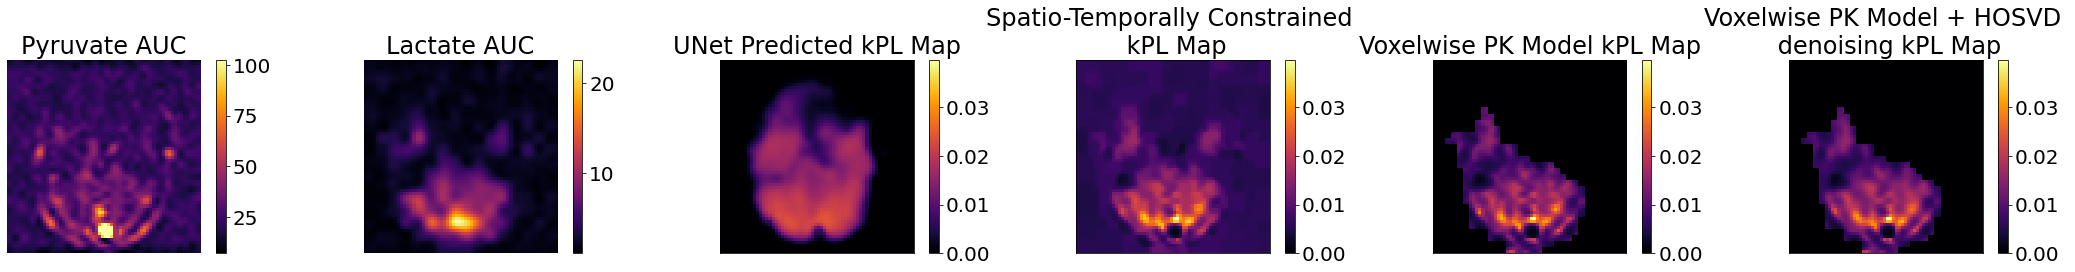

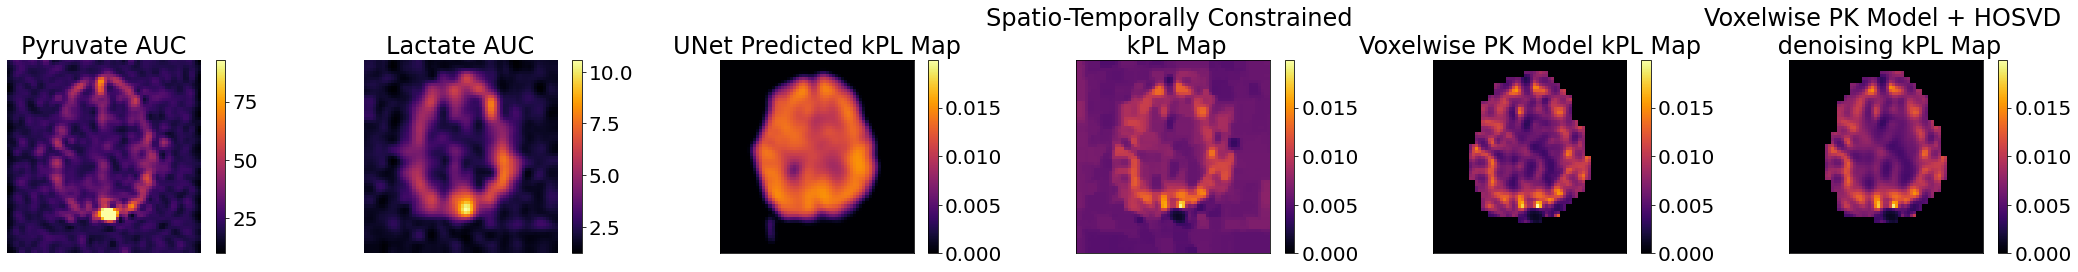

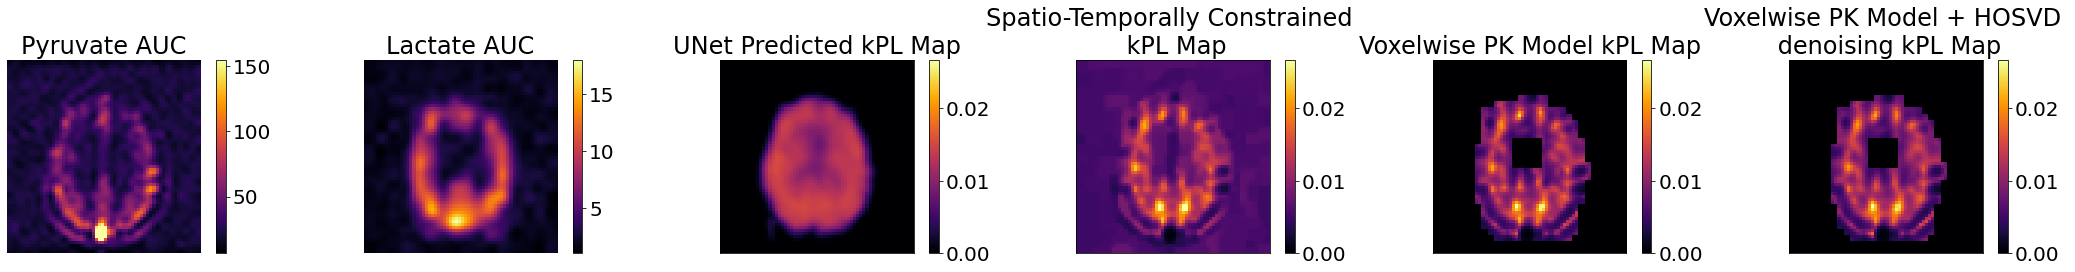

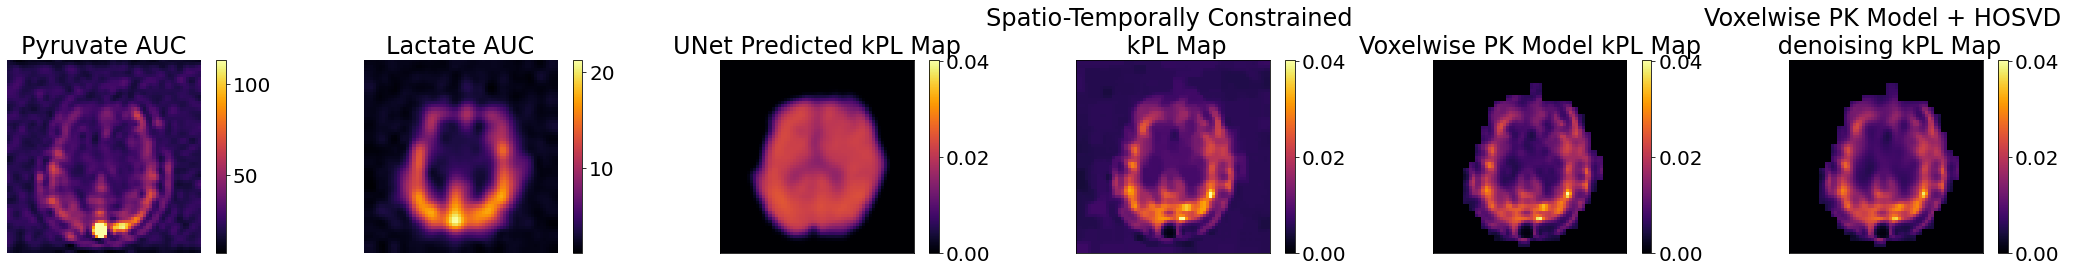

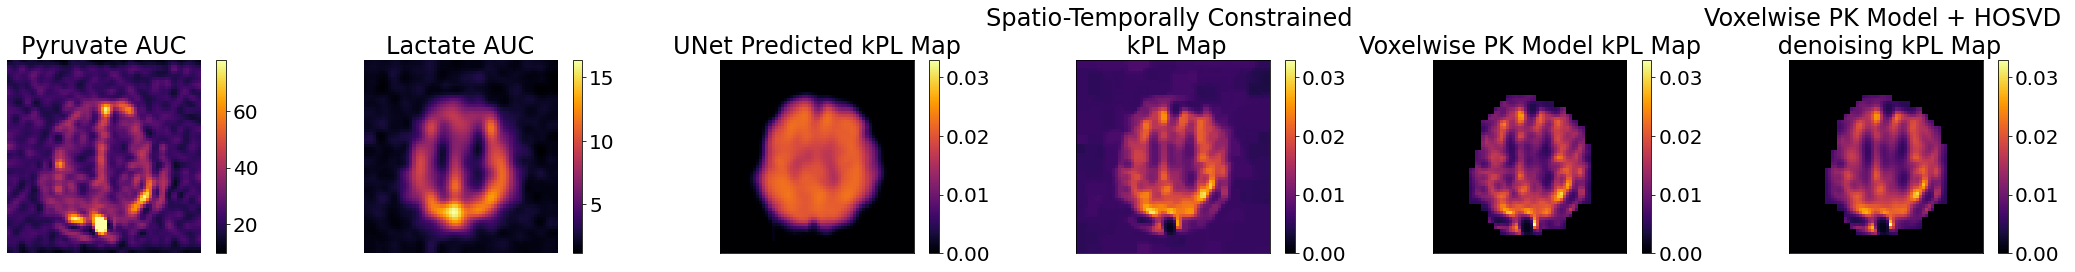

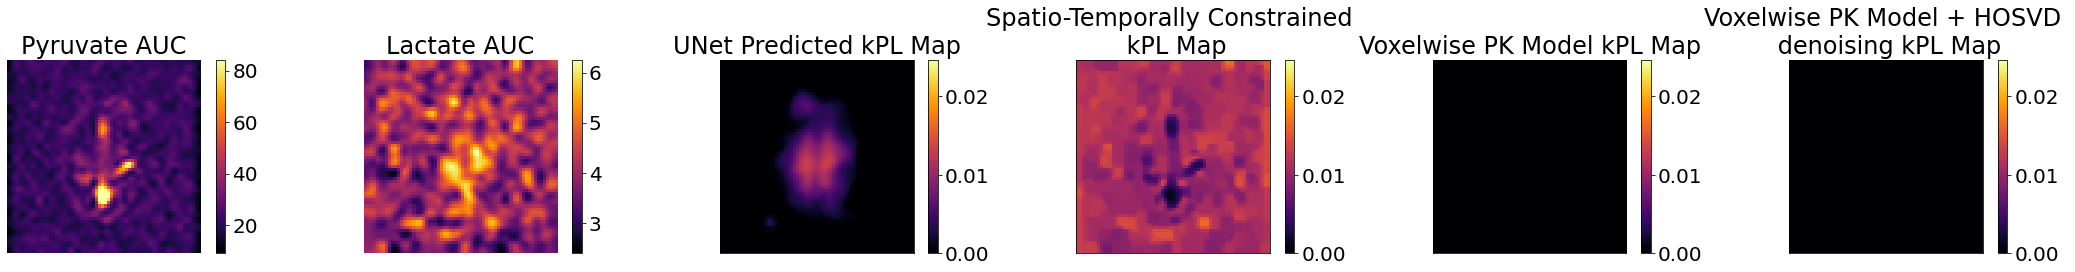

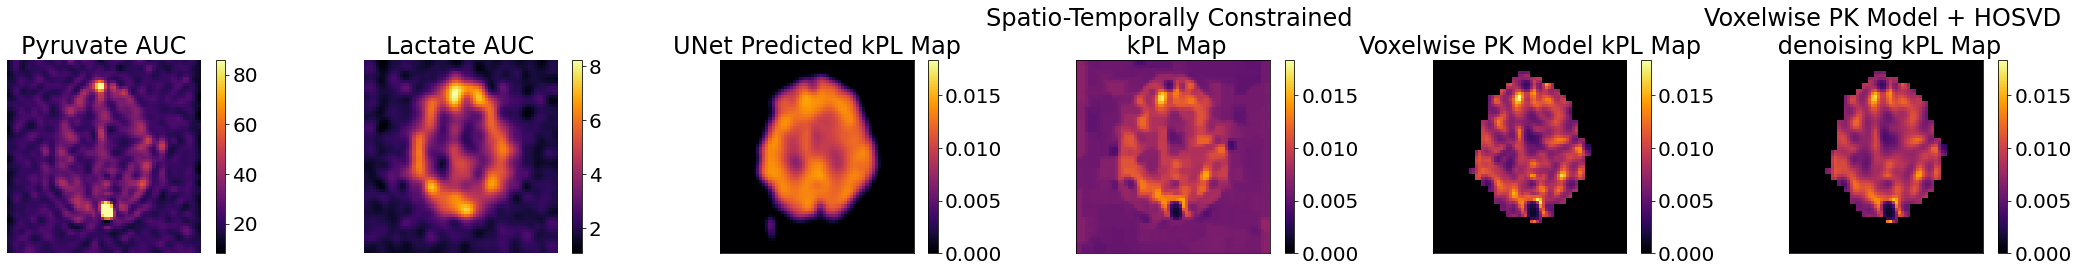

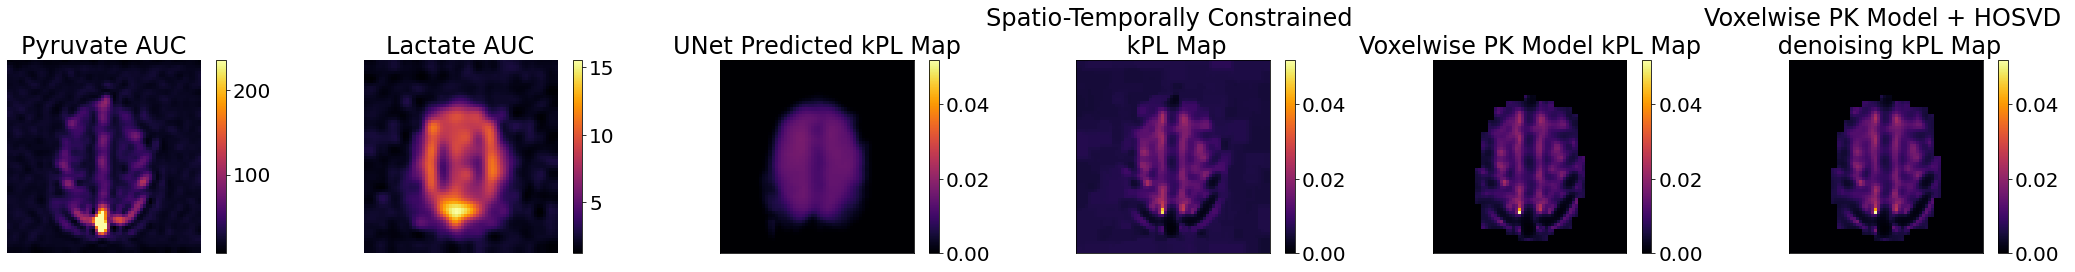

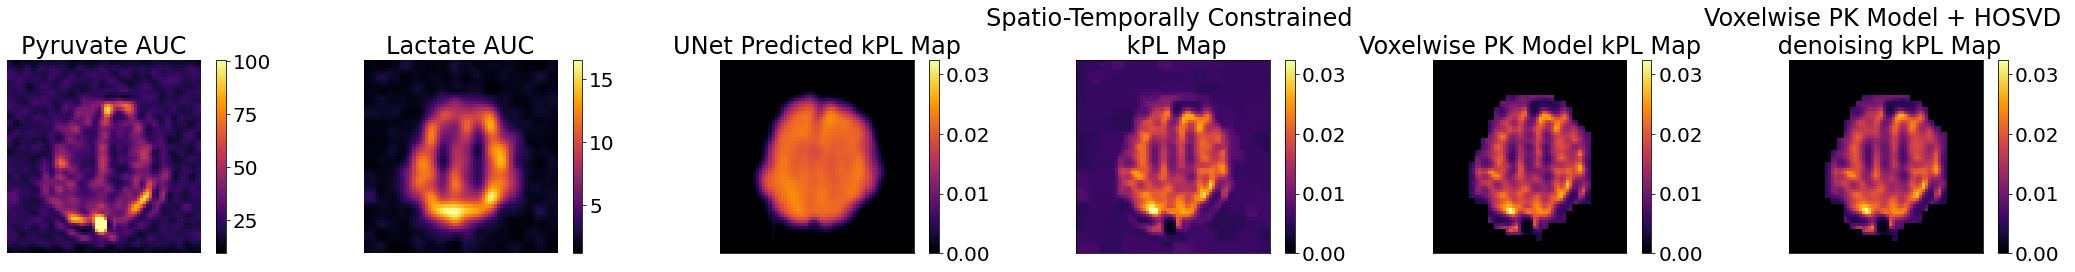

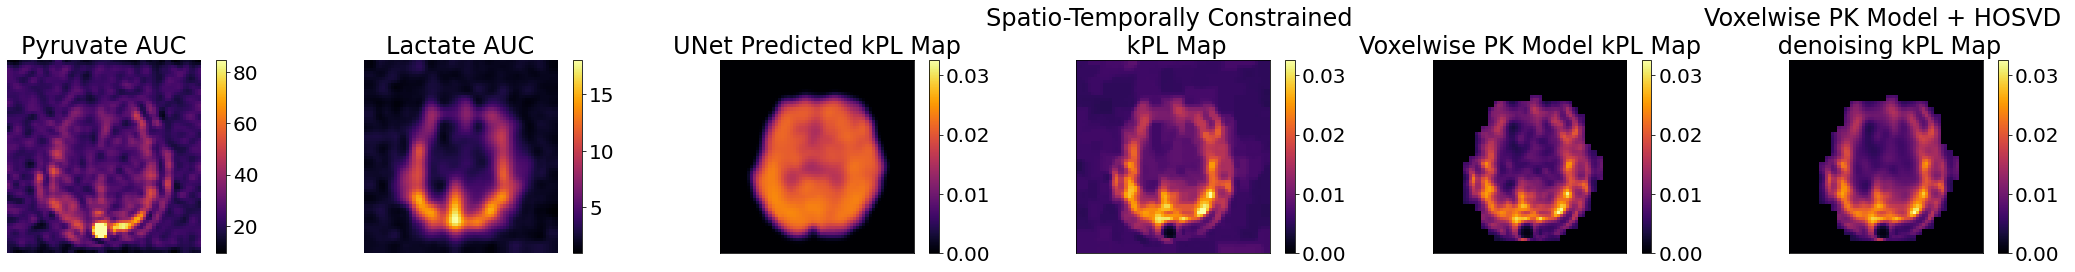

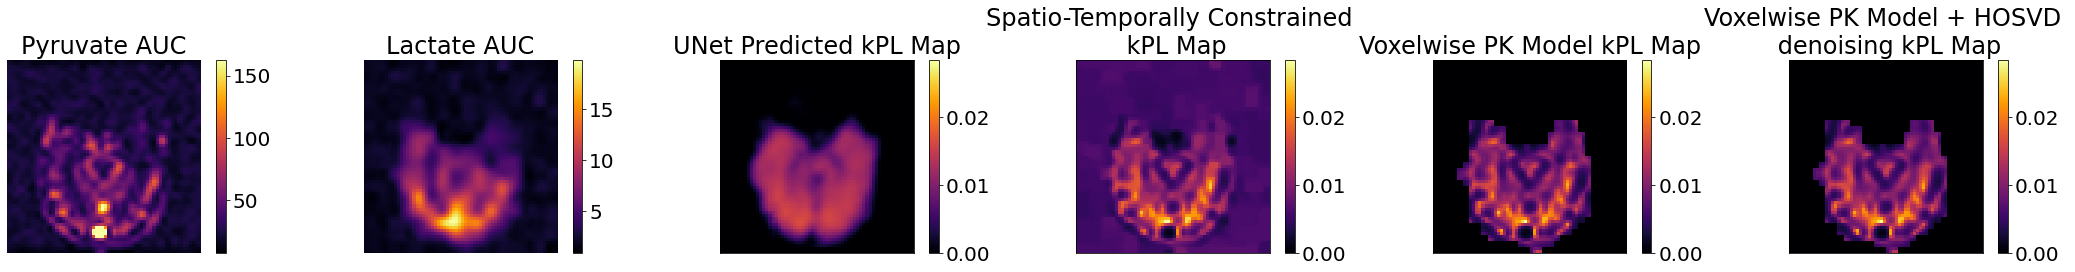

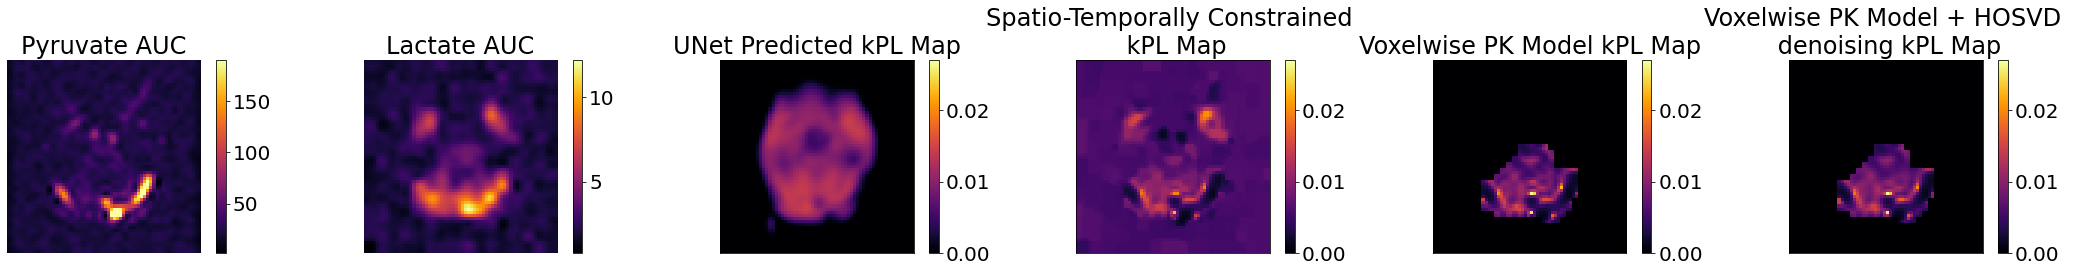

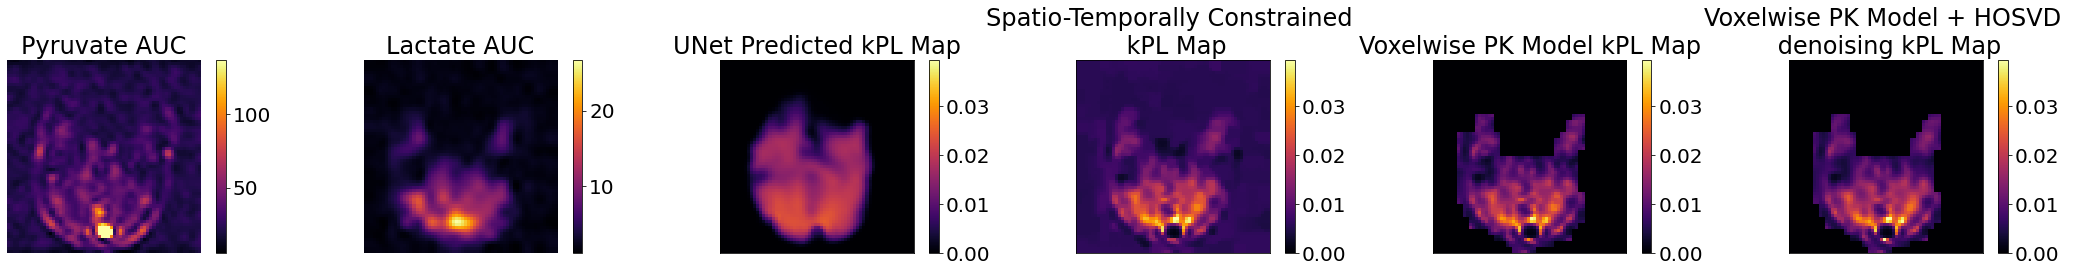

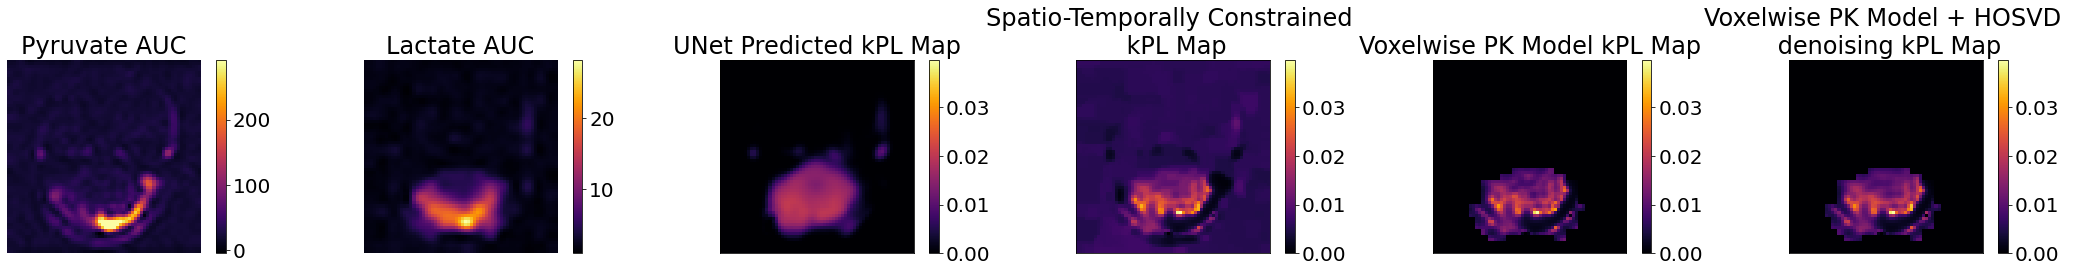

In [12]:
savepath = "/home/ssahin/kpl-est-dl/test_results/version_20/comp/invivo_2/"

for im in list_val:
    dictdata = read_data_invivo(im)
    num = im.split("/")[-1].split(".")[0]

    x = torch.from_numpy(dictdata["data"])
    x = x[None, :, :, :]
    with torch.no_grad():
        kpl_pred = model(x)
    kpl_pred_np = np.squeeze(kpl_pred.numpy())

    plot_comp_invivo(dictdata["data"], kpl_pred_np, dictdata["kPL_const"], dictdata["kPL_PK"], dictdata["kPL_denoise_PK"], dictdata["mask"], savepath = (savepath+num+".png"))


In [4]:
print(model)

UnetModel(
  (model): BasicUNet(
    (conv_0): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(60, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (conv_1): Convolution(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
    (down_1): Down(
      (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Convolution(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1,

In [11]:
print(summary(model, input_size=(2, 60, 64, 64)))

Layer (type:depth-idx)                                  Output Shape              Param #
UnetModel                                               --                        --
├─BasicUNet: 1-1                                        [2, 1, 64, 64]            --
│    └─TwoConv: 2-1                                     [2, 32, 64, 64]           --
│    │    └─Convolution: 3-1                            [2, 32, 64, 64]           17,376
│    │    └─Convolution: 3-2                            [2, 32, 64, 64]           9,312
│    └─Down: 2-2                                        [2, 32, 32, 32]           --
│    │    └─MaxPool2d: 3-3                              [2, 32, 32, 32]           --
│    │    └─TwoConv: 3-4                                [2, 32, 32, 32]           18,624
│    └─Down: 2-3                                        [2, 64, 16, 16]           --
│    │    └─MaxPool2d: 3-5                              [2, 32, 16, 16]           --
│    │    └─TwoConv: 3-6                         